# Tile-stats for wide-area map uncertainties

so ... in THEORY it's just the simple sum of squares equation  
`se_total = sqrt(sum(agbd_sd^2))`     
and for means:  
`se_mean = sqrt(sum(agbd_sd^2))/sqrt(n)`  
(n = number of pixels)

#### Notes:
+ are we sure that projecting the raster to 4326 doesnt alter `AGB` calcs? `AGB_pg = AGBD_mg_ha * 0.09 / 1e9` <-- but this only works if pixels are `0.09 ha` in size; and this changes in the reproject (pixels are now various sizes depending on latitude)

### Example run ot tile stats

In [671]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 

In [695]:
source('/projects/code/icesat2_boreal/lib/compute_tile_stats.r') 

In [717]:
compute_tile_stats('s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/v3.0.0/AGB_H30_2020/full_run/AGB_tindex_master.csv',
                   outdir_main='/projects/my-public-bucket/DPS_tile_lists/BOREAL_MAP', #TILE_NUM=3067,
                    start_idx=0, stop_idx=1000, REDO=FALSE) 

[1] "s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/v3.0.0/AGB_H30_2020/full_run/AGB_tindex_master.csv"
[1] "Tile num: 3067"
[1] 1 5
[1] "v3.0 AGB_H30_2020"
[1] 1
SpatExtent : 138.949530234288, 141.766408587449, 65.7763004168437, 66.8835549321696 (xmin, xmax, ymin, ymax)
SpatExtent : 138.949530234288, 141.766408587449, 65.7763004168437, 66.8835549321696 (xmin, xmax, ymin, ymax)
SpatExtent : 138.949530234288, 141.766408587449, 65.7763004168437, 66.8835549321696 (xmin, xmax, ymin, ymax)


In [659]:
library(aws.s3)
library(tidyverse)
library(dplyr)

library(fs)
library(sf)
library(patchwork)

library(terra)

library(raster)
library(viridis)

In [700]:
source('/projects/code/3dsi/boreal_map_functions.R') 

[1] "MAAP"
[1] "MAAP"


## Set output figure dir.

In [701]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_AGB/paper_figs'
dir.create(OUT_FIGURE_DIR)

#### Figure export function

In [757]:
EXPORT_PNG_PDF <- function(m_plot_figure, OUT_FIGURE_DIR, DATA_NAME_STEM, VAR, EXPORT_TIME_STR=format(Sys.time(), "_%Y%m%d"), FIG_DIMS=c(8,16), TYPE='map'){
    
    for(OUT_TYPE in c('png', 'pdf')){
        
        map_fn = path(OUT_FIGURE_DIR, paste0(TYPE,"_",DATA_NAME_STEM,"_", VAR, EXPORT_TIME_STR,".", OUT_TYPE))
        print(map_fn)
        
        ggsave(plot = m_plot_figure,
               file = map_fn,
               device = OUT_TYPE, dpi = 300, width=FIG_DIMS[1], height=FIG_DIMS[2])
    }
}

#### Get all tiles delivered to DAAC for this project

In [703]:
boreal_tile_DAAC_path = '/projects/shared-buckets/montesano/databank/daac/v3.0/boreal_tiles_v004_AGB_H30_2020_ORNLDAAC.gpkg'
boreal_tiles_gcs_DAAC = st_read(boreal_tile_DAAC_path) %>% st_transform(4326)
boreal_tile_num_DAAC_list =  boreal_tiles_gcs_DAAC %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_DAAC_list = unlist(boreal_tile_num_DAAC_list[[1]])
length(boreal_tile_num_DAAC_list)

Reading layer `boreal_tiles_v004_AGB_H30_2020_ORNLDAAC' from data source 
  `/projects/shared-buckets/montesano/databank/daac/v3.0/boreal_tiles_v004_AGB_H30_2020_ORNLDAAC.gpkg' 
  using driver `GPKG'
Simple feature collection with 3902 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: 43.75195 xmax: 180 ymax: 78.53133
Geodetic CRS:  WGS 84


[1] 3902

## Read in the tiles stats
+ originally lopped in `boreal_polar_maps_model_stats.ipynb`  
+ converted to a script `icesat2_boreal/lib/compute_tile_stats.R` (untested)

In [718]:
csv_fn_list = list.files('/projects/my-public-bucket/DPS_tile_lists/BOREAL_MAP/tile_stats_AGB_H30_2020_v3.0/tiles/', pattern='*.csv', full.names = TRUE)
single_map_version_tile_stats_df_list = list()
for(i in seq_along(csv_fn_list)){
    single_map_version_tile_stats_df_list[[i]] = read.csv(csv_fn_list[i], row.names=NULL)
    }

In [719]:
borealstats_df = do.call('rbind', single_map_version_tile_stats_df_list)
dim(borealstats_df)

[1] 4950  112

### From the start, change `AGB` to `AGBD` so everything downstream will be precise

In [720]:
names(borealstats_df) = str_replace(colnames(borealstats_df), '^agb_mean_','agbd_mean_')
names(borealstats_df) = str_replace(colnames(borealstats_df), '^agb_sd_','agbd_sd_')
names(borealstats_df) = str_replace(colnames(borealstats_df), '^agb_var_','agbd_var_')

### Convert to long format for plotting

#### adjust names 

In [722]:
borealstats_df_full = borealstats_df[, c(grep("_full|tile_num|tile_total_agb", colnames(borealstats_df)))]
names(borealstats_df_full) = str_replace(colnames(borealstats_df_full), '_full','')
names(borealstats_df_full) = str_replace(colnames(borealstats_df_full), 'tile_total_agb','total_agb')
borealstats_df_full$extent = 'full'
length(colnames(borealstats_df_full) )
names(borealstats_df_full)

[1] 37

[1] "agbd_mean.sum"       "agbd_mean.min"       "agbd_mean.mean"     
 [4] "agbd_mean.max"       "agbd_mean.sd"        "agbd_mean.X2."      
 [7] "agbd_mean.X25."      "agbd_mean.X50."      "agbd_mean.X75."     
[10] "agbd_mean.X98."      "agbd_sd.sum"         "agbd_sd.min"        
[13] "agbd_sd.mean"        "agbd_sd.max"         "agbd_sd.sd"         
[16] "agbd_sd.X2."         "agbd_sd.X25."        "agbd_sd.X50."       
[19] "agbd_sd.X75."        "agbd_sd.X98."        "agbd_var.sum"       
[22] "agbd_var.min"        "agbd_var.mean"       "agbd_var.max"       
[25] "agbd_var.sd"         "agbd_var.X2."        "agbd_var.X25."      
[28] "agbd_var.X50."       "agbd_var.X75."       "agbd_var.X98."      
[31] "tile_num"            "cnt"                 "total_agb_mean_pg"  
[34] "total_agb_sd_pg"     "total_agb_mean_mgha" "total_agb_sd_mgha"  
[37] "extent"

In [723]:
borealstats_df_boreal = borealstats_df[, c(grep("_boreal|tile_num|boreal_total_agb", colnames(borealstats_df)))]
names(borealstats_df_boreal) = str_replace(colnames(borealstats_df_boreal), '_boreal','')
names(borealstats_df_boreal) = str_replace(colnames(borealstats_df_boreal), 'boreal_total_agb','total_agb')
borealstats_df_boreal$extent = 'boreal'
length(colnames(borealstats_df_boreal) )
names(borealstats_df_boreal)

[1] 37

[1] "agbd_mean.sum"       "agbd_mean.min"       "agbd_mean.mean"     
 [4] "agbd_mean.max"       "agbd_mean.sd"        "agbd_mean.X2."      
 [7] "agbd_mean.X25."      "agbd_mean.X50."      "agbd_mean.X75."     
[10] "agbd_mean.X98."      "agbd_sd.sum"         "agbd_sd.min"        
[13] "agbd_sd.mean"        "agbd_sd.max"         "agbd_sd.sd"         
[16] "agbd_sd.X2."         "agbd_sd.X25."        "agbd_sd.X50."       
[19] "agbd_sd.X75."        "agbd_sd.X98."        "agbd_var.sum"       
[22] "agbd_var.min"        "agbd_var.mean"       "agbd_var.max"       
[25] "agbd_var.sd"         "agbd_var.X2."        "agbd_var.X25."      
[28] "agbd_var.X50."       "agbd_var.X75."       "agbd_var.X98."      
[31] "tile_num"            "cnt"                 "total_agb_mean_pg"  
[34] "total_agb_sd_pg"     "total_agb_mean_mgha" "total_agb_sd_mgha"  
[37] "extent"

In [724]:
borealstats_df_north = borealstats_df[, c(grep("_north|tile_num|tile_total_agb", colnames(borealstats_df)))]
names(borealstats_df_north) = str_replace(colnames(borealstats_df_north), '_north','')
names(borealstats_df_north) = str_replace(colnames(borealstats_df_north), 'tile_total_agb','total_agb') # THIS ISNT NORTH - JUST A PLACEHOLDER TO CHECK AGAINST

borealstats_df_north$extent = 'north'
length(colnames(borealstats_df_boreal) )
names(borealstats_df_boreal)

[1] 37

[1] "agbd_mean.sum"       "agbd_mean.min"       "agbd_mean.mean"     
 [4] "agbd_mean.max"       "agbd_mean.sd"        "agbd_mean.X2."      
 [7] "agbd_mean.X25."      "agbd_mean.X50."      "agbd_mean.X75."     
[10] "agbd_mean.X98."      "agbd_sd.sum"         "agbd_sd.min"        
[13] "agbd_sd.mean"        "agbd_sd.max"         "agbd_sd.sd"         
[16] "agbd_sd.X2."         "agbd_sd.X25."        "agbd_sd.X50."       
[19] "agbd_sd.X75."        "agbd_sd.X98."        "agbd_var.sum"       
[22] "agbd_var.min"        "agbd_var.mean"       "agbd_var.max"       
[25] "agbd_var.sd"         "agbd_var.X2."        "agbd_var.X25."      
[28] "agbd_var.X50."       "agbd_var.X75."       "agbd_var.X98."      
[31] "tile_num"            "cnt"                 "total_agb_mean_pg"  
[34] "total_agb_sd_pg"     "total_agb_mean_mgha" "total_agb_sd_mgha"  
[37] "extent"

In [725]:
borealstats_df_long = rbind(borealstats_df_full, borealstats_df_boreal, borealstats_df_north)
names(borealstats_df_long)

[1] "agbd_mean.sum"       "agbd_mean.min"       "agbd_mean.mean"     
 [4] "agbd_mean.max"       "agbd_mean.sd"        "agbd_mean.X2."      
 [7] "agbd_mean.X25."      "agbd_mean.X50."      "agbd_mean.X75."     
[10] "agbd_mean.X98."      "agbd_sd.sum"         "agbd_sd.min"        
[13] "agbd_sd.mean"        "agbd_sd.max"         "agbd_sd.sd"         
[16] "agbd_sd.X2."         "agbd_sd.X25."        "agbd_sd.X50."       
[19] "agbd_sd.X75."        "agbd_sd.X98."        "agbd_var.sum"       
[22] "agbd_var.min"        "agbd_var.mean"       "agbd_var.max"       
[25] "agbd_var.sd"         "agbd_var.X2."        "agbd_var.X25."      
[28] "agbd_var.X50."       "agbd_var.X75."       "agbd_var.X98."      
[31] "tile_num"            "cnt"                 "total_agb_mean_pg"  
[34] "total_agb_sd_pg"     "total_agb_mean_mgha" "total_agb_sd_mgha"  
[37] "extent"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


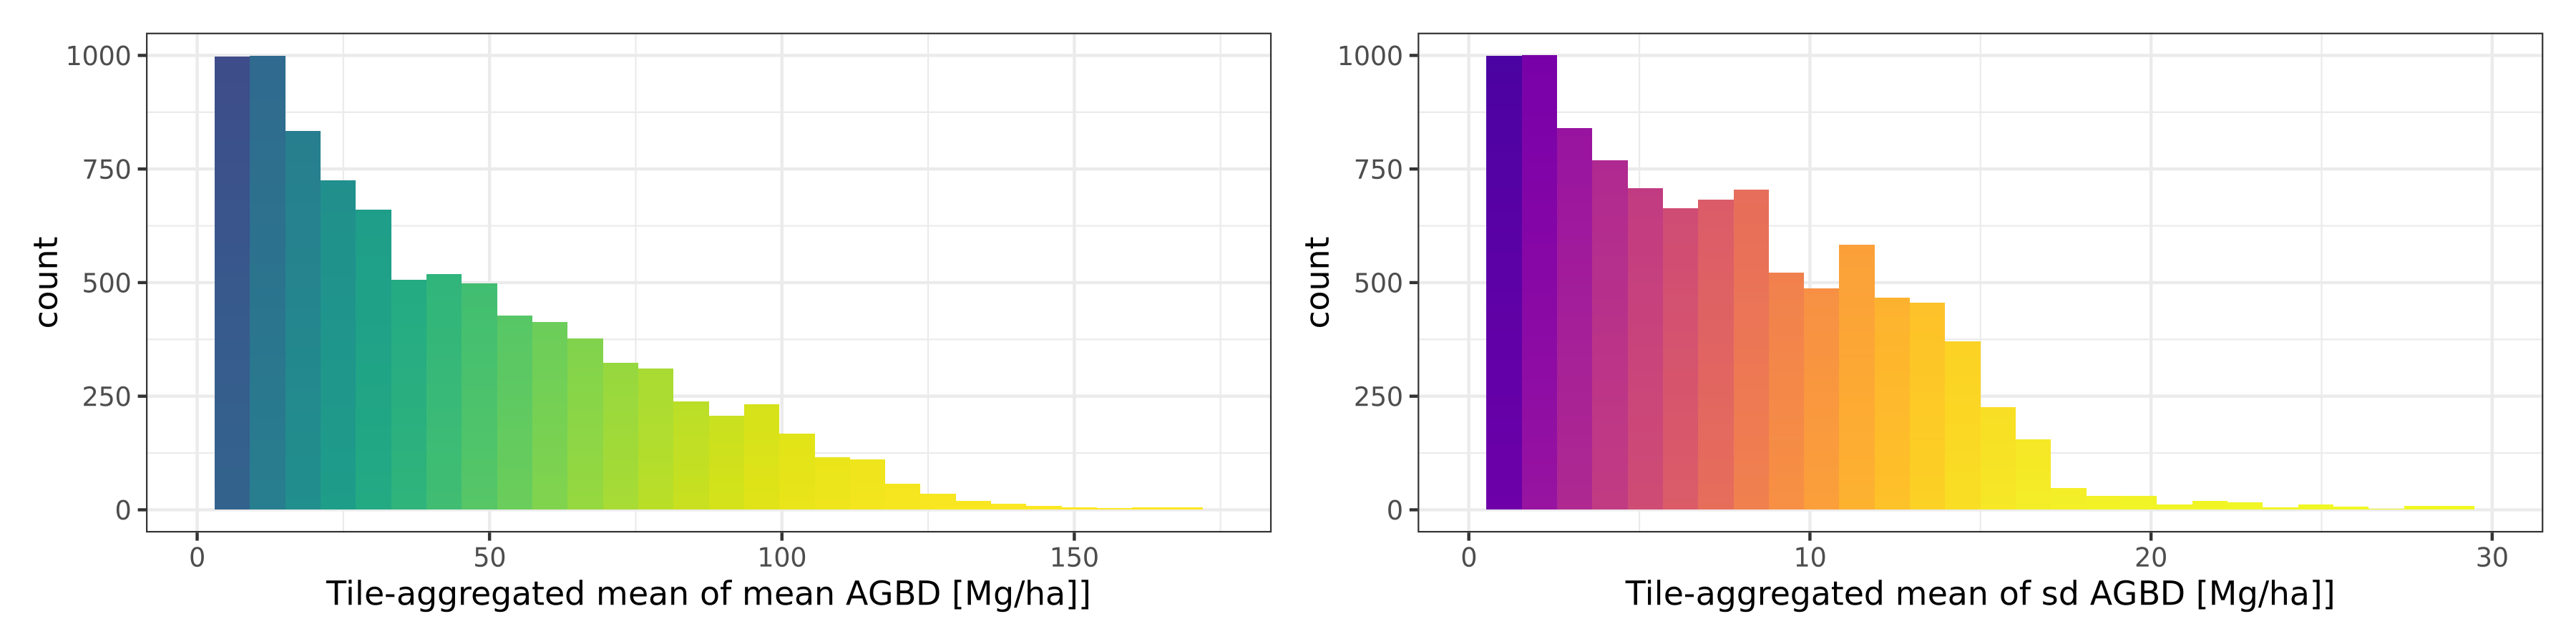

In [727]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300)

hist_agbd_mean.mean = ggplot(borealstats_df_long) +
    geom_histogram(aes(x=agbd_mean.mean, fill=factor(agbd_mean.mean)), show.legend=FALSE)+
    scale_fill_viridis_d(option='viridis', direction=1) +
    lims(x=c(0,175), y=c(0,1000)) +
    theme_bw() +
    labs(x='Tile-aggregated mean of mean AGBD [Mg/ha]]')

hist_agbd_sd.mean = ggplot(borealstats_df_long) +
    geom_histogram(aes(x=agbd_sd.mean, fill=factor(agbd_sd.mean)), show.legend=FALSE)+
    scale_fill_viridis_d(option='plasma', direction=1) +
    lims(x=c(0,30), y=c(0,1000)) +
    theme_bw() +
    labs(x='Tile-aggregated mean of sd AGBD [Mg/ha]]')
    #custom_theme +
    #labs(x=expression("First rF model RMSE ["~Mg~ha^{-1}~"]"))

hist_agbd_mean.mean | hist_agbd_sd.mean

## Domain (extent) totals with standard errors

#### Sum and convert AGBD to AGB: 
use summed pixels of AGBD (Mg/ha) to get total stock AGB

In [728]:
convert_density_to_stock <- function(col_mgha_sum){
    Mg_per_Pg = 1e9
    ha_per_pixel = 0.09
    col_pg_total = col_mgha_sum * (ha_per_pixel / Mg_per_Pg)
    return(col_pg_total)
    }

### from PMM

In [729]:
borealstats_df_long = borealstats_df_long %>% 
        mutate(
            agb_pg_total = convert_density_to_stock(agbd_mean.sum),
            agb_pg_var = convert_density_to_stock(agbd_var.sum),
        )

In [731]:
smry_domain_total_pmm = borealstats_df_long %>% 
    filter(agb_pg_total > 0) %>% # ignore where 0, to get the correct n_tiles_used for each extent
    group_by(extent) %>%
    #drop_na() %>%  # north had an NA row for tile 4029 (ocean near BC)
    summarize(
        source='PMM',
        n_tiles_used = n(),
        n_pix_billions = sum(cnt)/1e9,
        agb_pg_total_domain = sum(agb_pg_total, rm.na=TRUE),
        agb_pg_se_total_domain = sqrt(sum(agb_pg_var)), #se_total = sqrt(sum(agbd_sd^2))
        agb_pg_se_mean_domain = sqrt(sum(agb_pg_var))/sqrt(sum(cnt)), # se_mean = sqrt(sum(agbd_sd^2))/sqrt(n)
        ) 
smry_domain_total_pmm

extent source n_tiles_used n_pix_billions agb_pg_total_domain
1 boreal PMM    3003         19.80854        73.32011          
2 full   PMM    4950         35.93117       115.56487          
3 north  PMM    3579         25.44539        77.44072          
  agb_pg_se_total_domain agb_pg_se_mean_domain
1 12.10224               8.598838e-05         
2 17.58923               9.279213e-05         
3 13.14350               8.239603e-05

### from LD

### Tile AGB summary (LD)

+ I think the:
    +  `Tile_northern_tot_var` and `Tile_boreal_tot_var` fields are still in `Mg/ha`
    +   `Tile_northern_AGB` and  `Tile_boreal_AGB` are in `Pg`

In [732]:
borealstats_df_ld = read.csv('/projects/shared-buckets/lduncanson/above_boreal/tile_agb_summary.csv')
#borealstats_df_ld = borealstats_df_ld %>% dplyr::mutate(tile_num = tiles) %>% dplyr::select(-tiles)
names(borealstats_df_ld) # original names

[1] "tiles"                 "Tile_northern_AGB"     "Tile_northern_tot_var"
[4] "Tile_boreal_AGB"       "Tile_boreal_tot_var"   "Tile_mean_AGBD"       
[7] "Tile_mean_SD"

In [733]:
# new names to be able to bind to my borealstats df later
names(borealstats_df_ld) = c('tile_num',
                          'agb_mean_north.sum','agb_var_north.sum', # north 
                          'agb_mean_boreal.sum','agb_var_boreal.sum', 
                          'agbd_mean_full.mean','agbd_sd_full.mean')

tail(head(borealstats_df_ld,2000))

tile_num agb_mean_north.sum agb_var_north.sum agb_mean_boreal.sum
1995 26561    0.00000000                  0        0                  
1996 26562    0.00000000                  0        0                  
1997 26563    0.03364350          909774458        0                  
1998 26564    0.06610293         1997795889        0                  
1999 26565    0.07171633         2077487380        0                  
2000 26566    0.09334601         3252803826        0                  
     agb_var_boreal.sum agbd_mean_full.mean agbd_sd_full.mean
1995 0                  44.39250            10.31200         
1996 0                  48.96784            10.38122         
1997 0                  63.87267            11.12950         
1998 0                  51.08612            10.23854         
1999 0                  54.72657            10.28090         
2000 0                  70.48132            13.01840

In [735]:
z = borealstats_df_ld %>%
    filter(agb_mean_north.sum >= 0)
dim(z)

[1] 4948    7

In [738]:
smry_boreal_total_ld = borealstats_df_ld %>%
    ##filter(Tile_boreal_AGB > 0) %>%
    drop_na() %>%  # north had an NA row for tile 4029 (ocean near BC)
    summarize(
        extent = 'boreal',
        source='LD',
        n_tiles_used = n(),
        n_pix_billions = NA,
        agb_pg_total_domain = sum(agb_mean_boreal.sum, rm.na=TRUE), #agb_pg_total_domain = sum(Tile_boreal_AGB, rm.na=TRUE),
        agb_pg_se_total_domain = sqrt(sum(agb_var_boreal.sum)*0.09/1e9)  , # need to convert LD var total from Mgha to Pg
        agb_pg_se_mean_domain = NA
        ) 
smry_north_total_ld = borealstats_df_ld %>%
    ##filter(Tile_northern_AGB > 0) %>%
    drop_na() %>%  # north had an NA row for tile 4029 (ocean near BC)
    summarize(
        extent = 'north',
        source='LD',
        n_tiles_used = n(),
        n_pix_billions = NA,
        agb_pg_total_domain = sum(agb_mean_north.sum, rm.na=TRUE),
        agb_pg_se_total_domain = sqrt(sum(agb_var_north.sum)*0.09/1e9) ,# need to convert LD var total from Mgha to Pg
        agb_pg_se_mean_domain = NA
        )  %>%
    mutate()
smry_full_total_ld = data.frame(matrix(NA,nrow=1, ncol=length(smry_north_total_ld)))
names(smry_full_total_ld) = colnames(smry_north_total_ld)
smry_full_total_ld = smry_full_total_ld %>% mutate(extent='full', source='LD')
smry_domain_total_ld = rbind(smry_boreal_total_ld, smry_full_total_ld, smry_north_total_ld)
smry_domain_total_ld

extent source n_tiles_used n_pix_billions agb_pg_total_domain
1 boreal LD     4948         NA             73.31133           
2 full   LD       NA         NA                   NA           
3 north  LD     4948         NA             88.03018           
  agb_pg_se_total_domain agb_pg_se_mean_domain
1 12.10133               NA                   
2       NA               NA                   
3 14.38869               NA

In [739]:
smry_domain_total = rbind(smry_domain_total_pmm, smry_domain_total_ld)

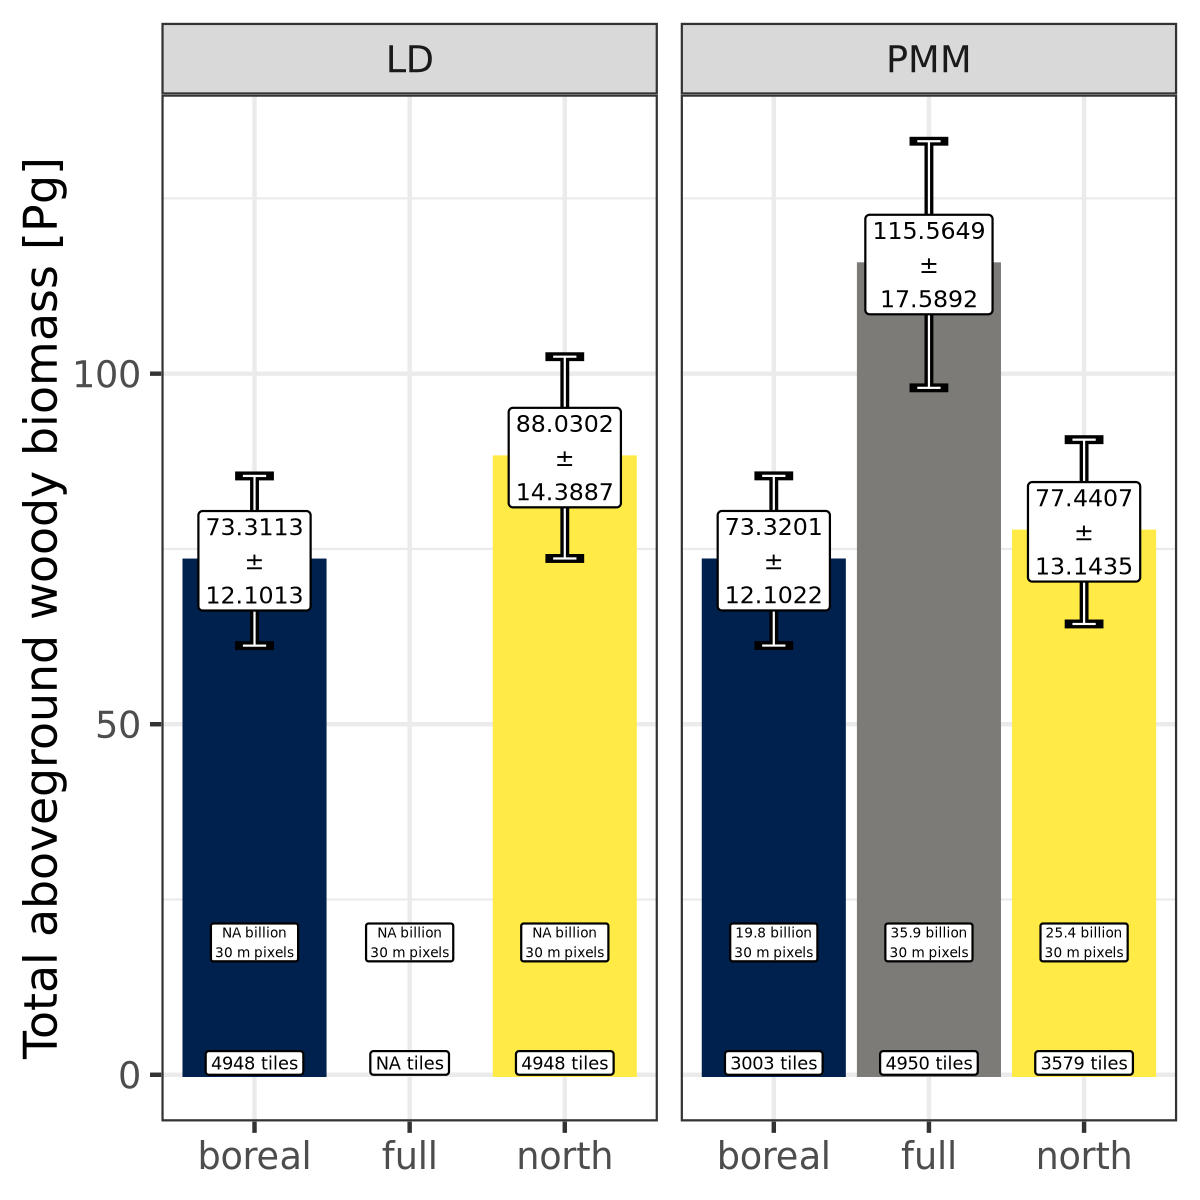

In [741]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)

p_bar_smry = ggplot(smry_domain_total, aes(x=extent, y=agb_pg_total_domain )) + # aes(reorder(variable, value), value)
    geom_bar(aes(fill=extent, color=extent), stat="identity") +
    geom_errorbar(aes(ymin = agb_pg_total_domain - agb_pg_se_total_domain, ymax = agb_pg_total_domain + agb_pg_se_total_domain), 
                width = 0.25, size=1 ) +
    geom_errorbar(aes(ymin = agb_pg_total_domain - agb_pg_se_total_domain, ymax = agb_pg_total_domain + agb_pg_se_total_domain), 
                width = 0.15, size=0.25 , color='white') +
    geom_label(aes(label = paste0(round(agb_pg_total_domain,4),"\n±\n", round(agb_pg_se_total_domain,4) )), vjust = 0.5, size=2) +  # Add labels above bars
    geom_label(aes(y=0, label = paste0(round(n_pix_billions,1),' billion\n30 m pixels')), vjust = -3, size=1.15) +  # Add labels above bars
    geom_label(aes(y=0, label = paste0(n_tiles_used, ' tiles')), vjust = 0, size=1.5) +  # Add labels above bars
    scale_fill_viridis_d(option = 'cividis', direction=1, aesthetics=c('fill','color'), guide=FALSE) +
    theme_bw() +
    theme(axis.text.x = element_text(angle=0)) +
    facet_wrap(.~source, ncol=2) +
    labs(y='Total aboveground woody biomass [Pg]', x=NULL)
p_bar_smry

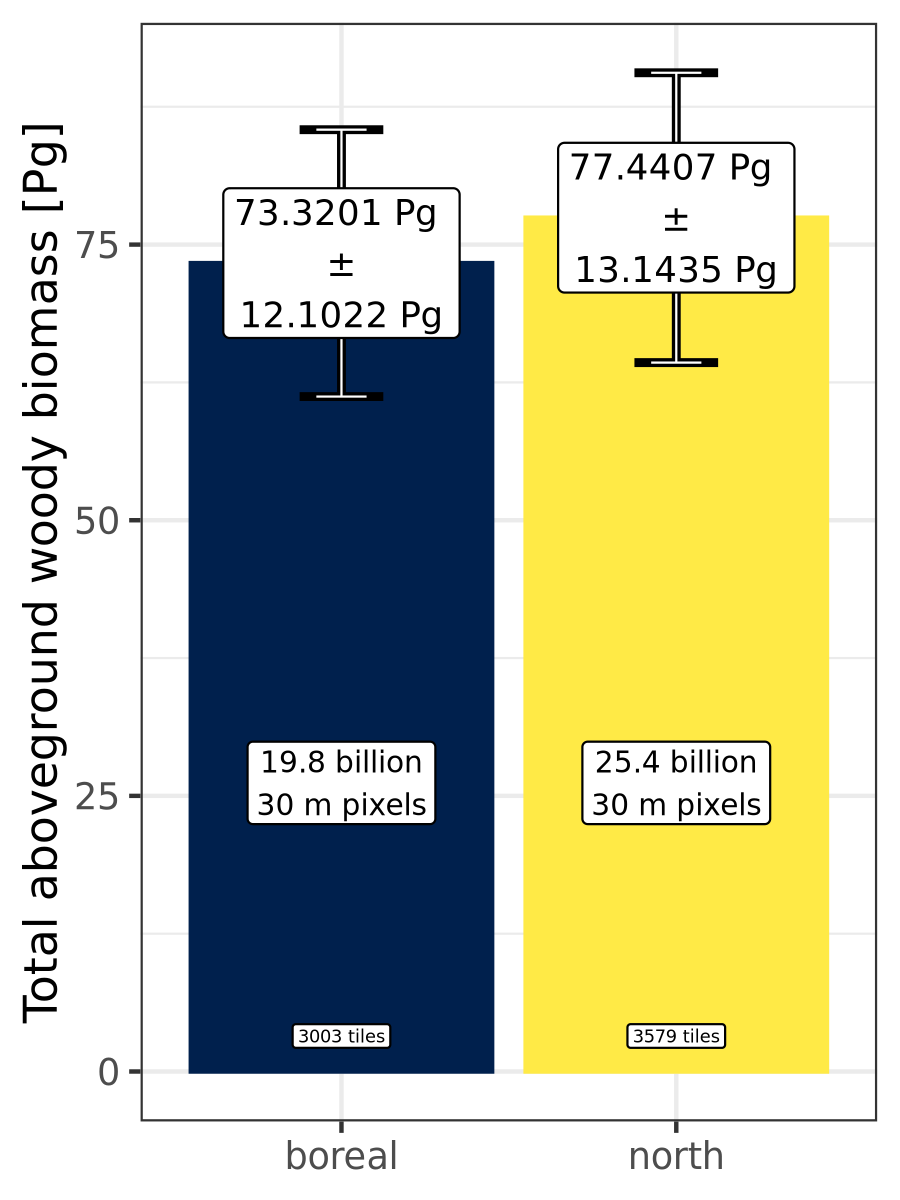

In [755]:
options(repr.plot.width = 3, repr.plot.height = 4, repr.plot.res = 300)

p_bar_smry_PMM = ggplot(smry_domain_total %>% filter((source=='PMM'), (extent != 'full')), aes(x=extent, y=agb_pg_total_domain )) + # aes(reorder(variable, value), value)
    geom_bar(aes(fill=extent, color=extent), stat="identity") +
    geom_errorbar(aes(ymin = agb_pg_total_domain - agb_pg_se_total_domain, ymax = agb_pg_total_domain + agb_pg_se_total_domain), 
                width = 0.25, size=1 ) +
    geom_errorbar(aes(ymin = agb_pg_total_domain - agb_pg_se_total_domain, ymax = agb_pg_total_domain + agb_pg_se_total_domain), 
                width = 0.15, size=0.25 , color='white') +
    geom_label(aes(label = paste0(round(agb_pg_total_domain,4)," Pg \n±\n", round(agb_pg_se_total_domain,4), " Pg" )), vjust = 0.5, size=3) +  # Add labels above bars
    geom_label(aes(y=0, label = paste0(round(n_pix_billions,1),' billion\n30 m pixels')), vjust = -3, size=2.5) +  # Add labels above bars
    geom_label(aes(y=0, label = paste0(n_tiles_used, ' tiles')), vjust = -1, size=1.5) +  # Add labels above bars
    scale_fill_viridis_d(option = 'cividis', direction=1, aesthetics=c('fill','color'), guide=FALSE) +
    theme_bw() +
    theme(axis.text.x = element_text(angle=0)) +
    #facet_wrap(.~source, ncol=2) +
    labs(y='Total aboveground woody biomass [Pg]', x=NULL)
p_bar_smry_PMM

In [758]:
EXPORT_PNG_PDF(p_bar_smry_PMM, OUT_FIGURE_DIR, 'tile_stats_bars', 'TOTAL_Pg', EXPORT_TIME_STR=format(Sys.time(), "_%Y%m%d"), FIG_DIMS=c(3,4), TYPE='plot')

/projects/my-public-bucket/boreal_AGB/paper_figs/plot_tile_stats_bars_TOTAL_Pg_20250724.png
/projects/my-public-bucket/boreal_AGB/paper_figs/plot_tile_stats_bars_TOTAL_Pg_20250724.pdf


### Combine `borealstats_df` with `borealstats_df_ld` to combine tile-level `north` sums

In [769]:
names(borealstats_df_pmm_cleaned)
names(borealstats_df_ld_cleaned)

[1] "tile_num"     "agb_pg_total" "extent"       "source"

[1] "tile_num"            "agb_mean_boreal.sum" "agb_pg_total"       
[4] "extent"              "source"

In [770]:
borealstats_df_pmm_cleaned = borealstats_df %>% 
        dplyr::select(tile_num, agbd_mean_boreal.sum) %>%
        mutate(
                agb_pg_total = convert_density_to_stock(agbd_mean_boreal.sum),
                extent = 'boreal',
                source = 'PMM'
                ) %>% 
        dplyr::select(-agbd_mean_boreal.sum)

borealstats_df_ld_cleaned =  borealstats_df_ld %>% 
        dplyr::select(tile_num, agb_mean_boreal.sum) %>%
        mutate(
                #tile_num = tiles,
                agb_pg_total = agb_mean_boreal.sum,
                extent = 'boreal',
                source = 'LD'
            ) %>%
        #dplyr::select(-c(tiles, Tile_boreal_AGB))
        dplyr::select(-c(agb_mean_boreal.sum))

# Rbind the 2 - mimicking a melted df
borealstats_df_pmm_ld_rbind = rbind(borealstats_df_pmm_cleaned, borealstats_df_ld_cleaned   )

borealstats_df_pmm_ld_merged <- merge(borealstats_df_pmm_cleaned, borealstats_df_ld_cleaned, by = "tile_num", all = TRUE)

borealstats_df_pmm_ld_merged = borealstats_df_pmm_ld_merged %>% mutate(diff_agb_pg_total = agb_pg_total.y - agb_pg_total.x)

In [771]:
LARGEST_DIFF = max(borealstats_df_pmm_ld_merged$diff_agb_pg_total, na.rm=TRUE)
borealstats_df_pmm_ld_merged[which(borealstats_df_pmm_ld_merged$diff_agb_pg_total == LARGEST_DIFF),]

tile_num agb_pg_total.x extent.x source.x agb_pg_total.y extent.y source.y
2338 2477     0.1034621      boreal   PMM      0.1034621      boreal   LD      
     diff_agb_pg_total
2338 8.049117e-16

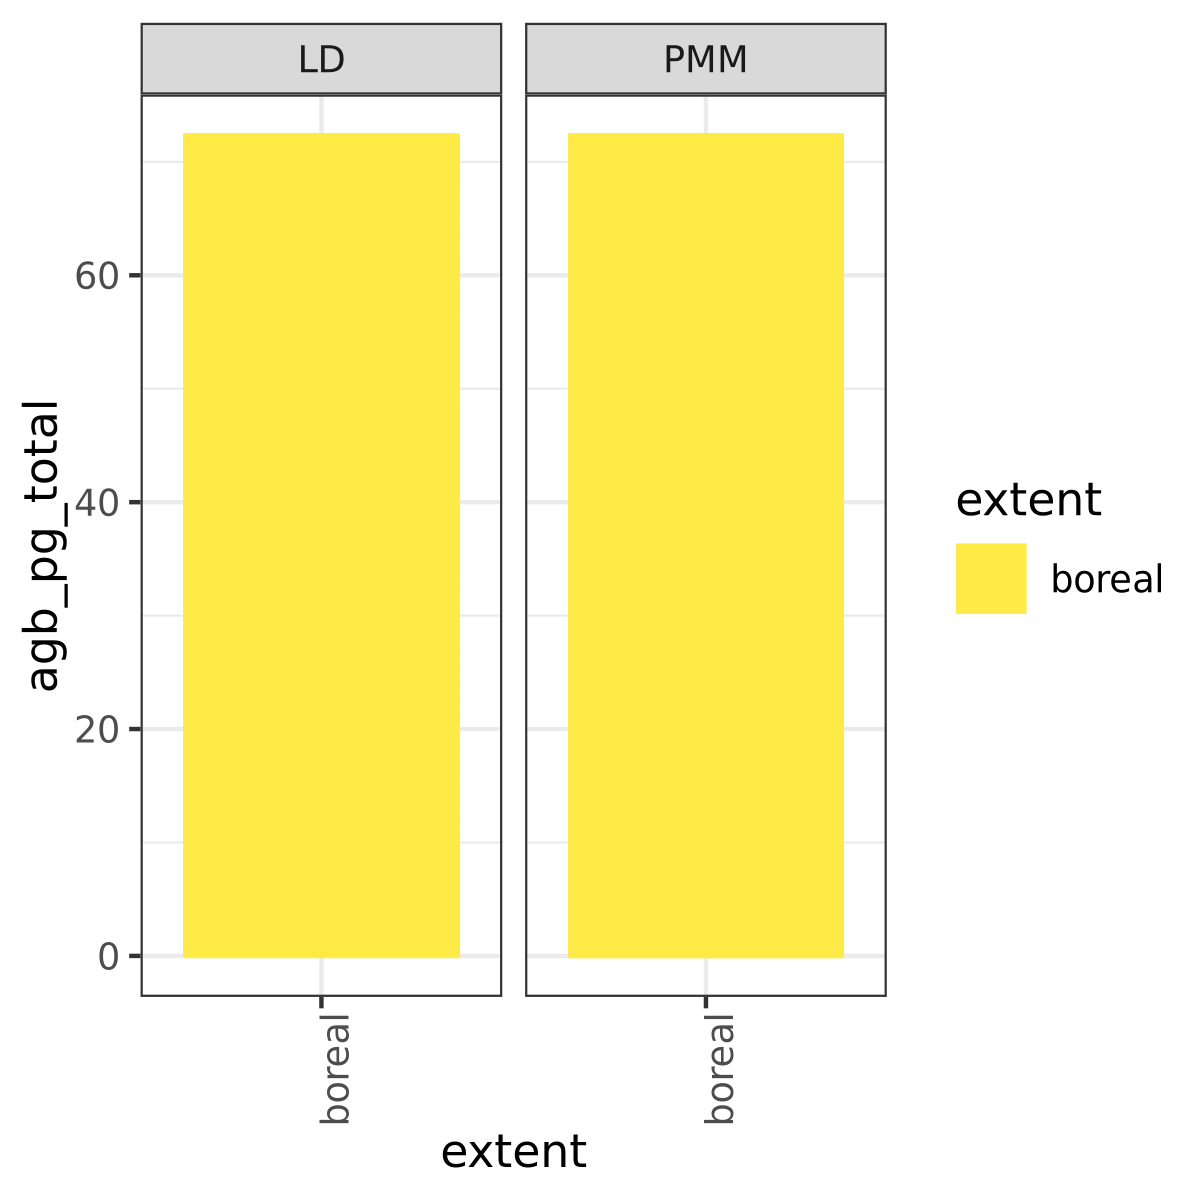

In [452]:
ggplot(borealstats_df_pmm_ld_rbind) + # aes(reorder(variable, value), value)
        geom_bar(aes(x=extent, y=agb_pg_total , fill=extent, color=extent), stat="identity") +
        scale_fill_viridis_d(option = 'cividis', direction=-1, aesthetics=c('fill','color')) +
        theme_bw() +
        theme(axis.text.x = element_text(angle=90)) +
        facet_wrap(~source, ncol=2)

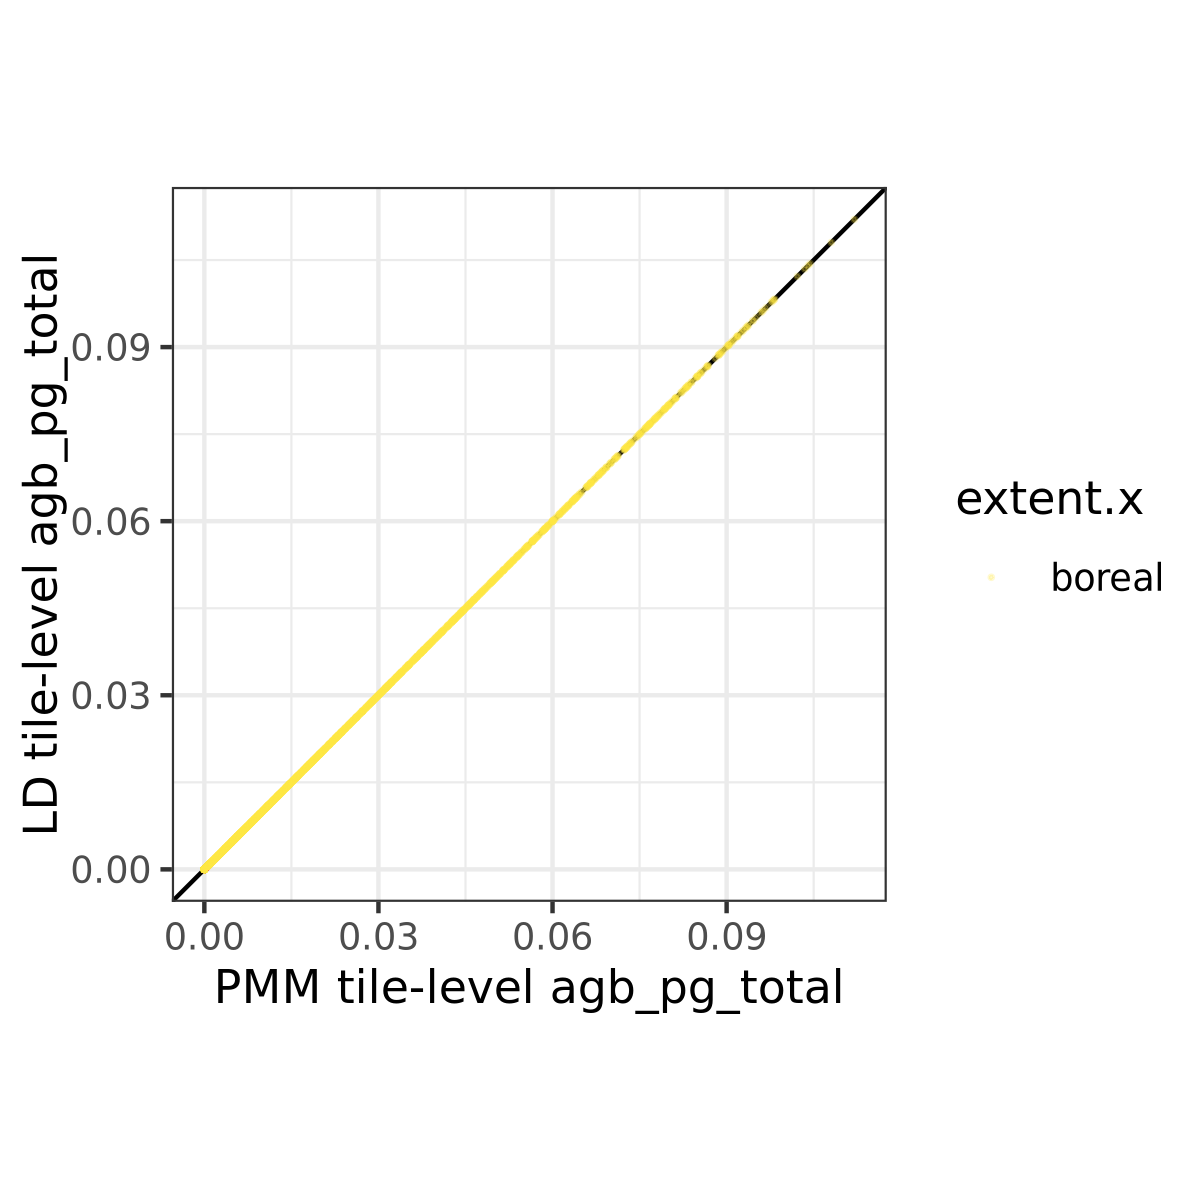

In [453]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)

ggplot(borealstats_df_pmm_ld_merged) + 
    geom_abline() +
    geom_point(aes(x=agb_pg_total.x , y=agb_pg_total.y, color=extent.x), size=.2
                    , alpha=0.25
                   ) +

    scale_fill_viridis_d(option = 'cividis', direction=-1, aesthetics=c('fill','color')) +
    labs(y='LD tile-level agb_pg_total', x='PMM tile-level agb_pg_total') + 
    coord_equal() +
    theme_bw()

## Stock total (Pg) PMM code aligned with LD code (looping over rasters with functions in `compute_tiles_stats.R`)

In [196]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 300)
DO_PLOTS <- function(df, PLOT_VAR){

    #df = df %>% filter(.data[[PLOT_VAR]] > 0)
    
    p_bar = ggplot(df) + # aes(reorder(variable, value), value)
        geom_bar(aes(x=extent, y=.data[[PLOT_VAR]] , fill=extent, color=extent), stat="identity") +
        scale_fill_viridis_d(option = 'cividis', aesthetics=c('fill','color')) +
        theme_bw() +
        theme(axis.text.x = element_text(angle=90))

    p_hist = ggplot(df) + # aes(reorder(variable, value), value)
        geom_histogram(aes( x=.data[[PLOT_VAR]] , fill=extent)) +
        scale_fill_viridis_d(option = 'cividis', aesthetics=c('fill','color')) +
        theme_bw() +
        facet_wrap(~extent, ncol=3) +
        theme(axis.text.x = element_text(angle=90))
    p_bar | p_hist
    #return(p_bar, p_hist)
    }

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


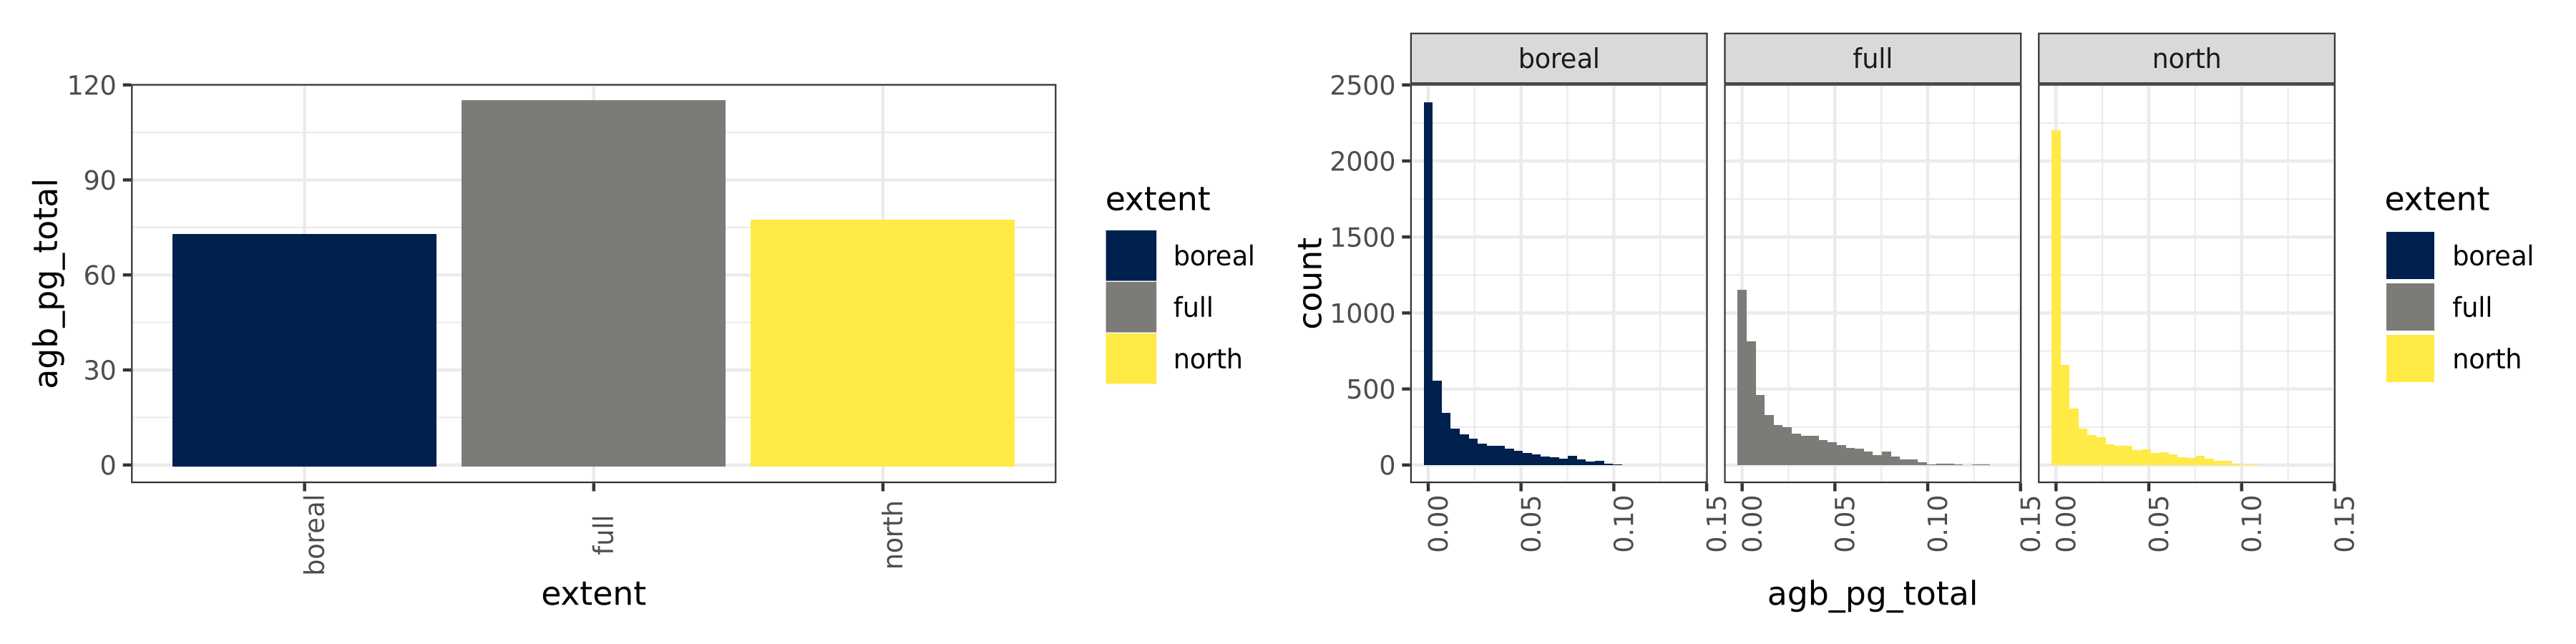

In [197]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300)

DO_PLOTS(borealstats_df_long, 'agb_pg_total')

## Stock total (Pg) from original PMM calc (using `*_summary.csv` file from each tile)
#### (ignore `north` b/c original PMM didnt do that calc - copied `full` as a placeholder)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


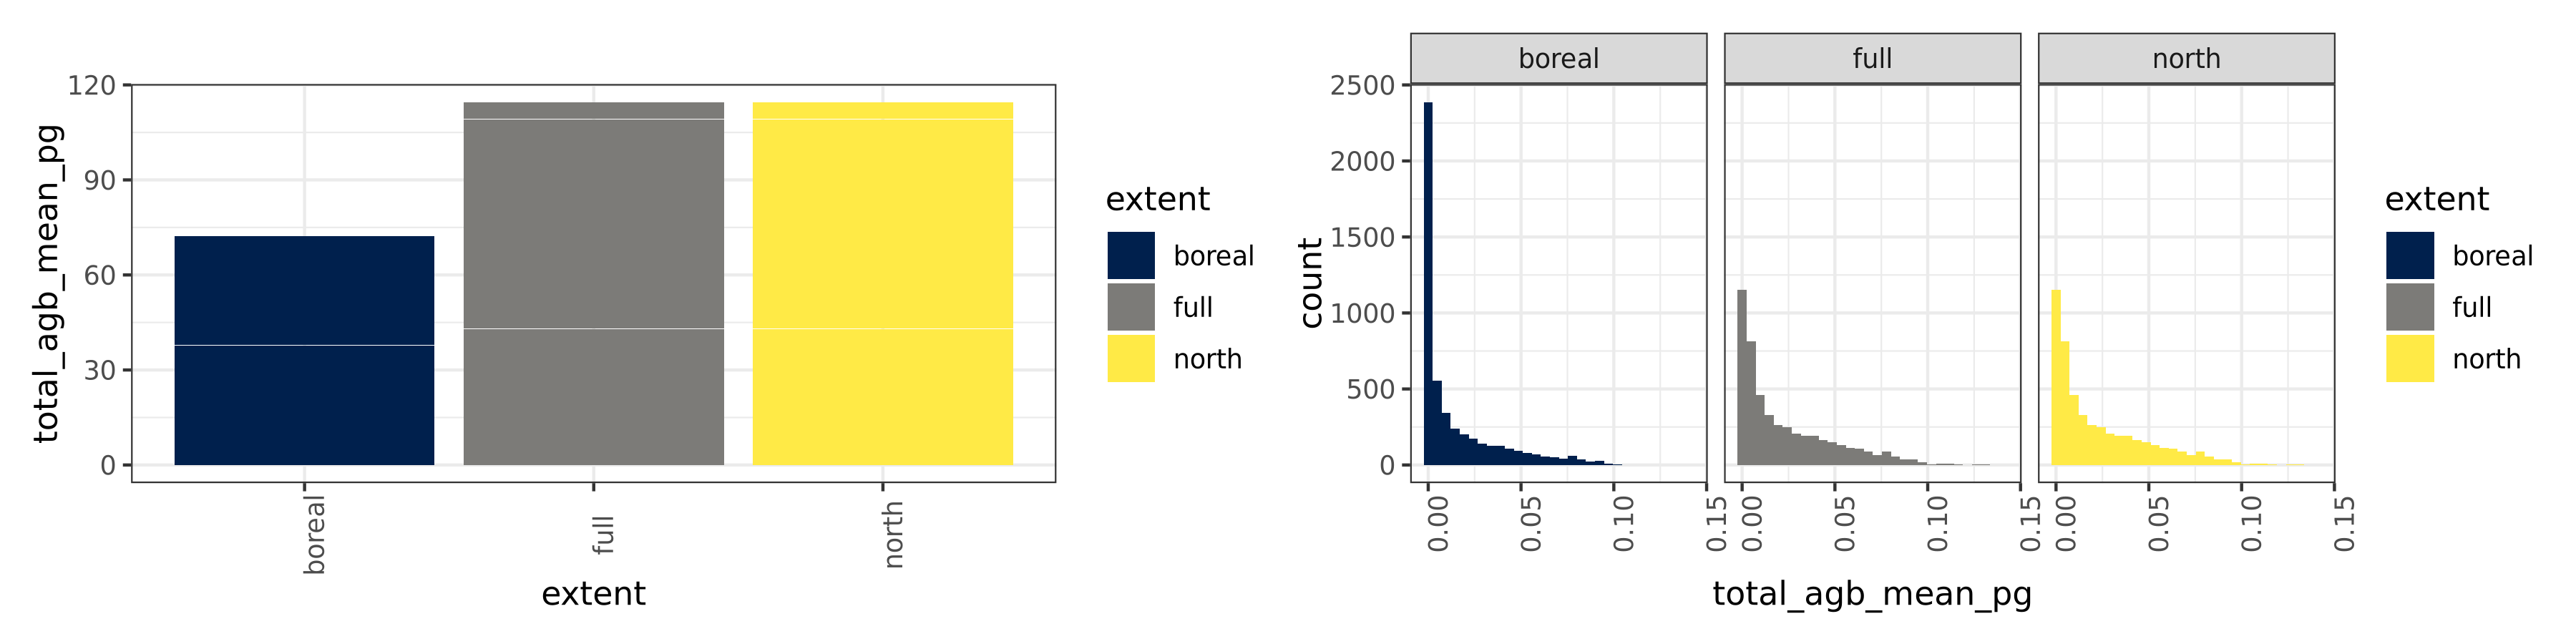

In [175]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300)

DO_PLOTS(borealstats_df_long, 'total_agb_mean_pg')

In [176]:
plot_stat_mean = 'agbd_mean.mean'
PLOT_STAT_ERRBAR_1 = 'agbd_mean.sd' # This is the sd of the per-pixel MEAN values (larger) - this is a measure of geographic variation of AGBD from within tile
PLOT_STAT_ERRBAR_2 = 'agbd_sd.mean' # This is the mean of the per-pixel SD values (smaller) - this is a measure of AGBD uncertainty at pixel-level from within a tile

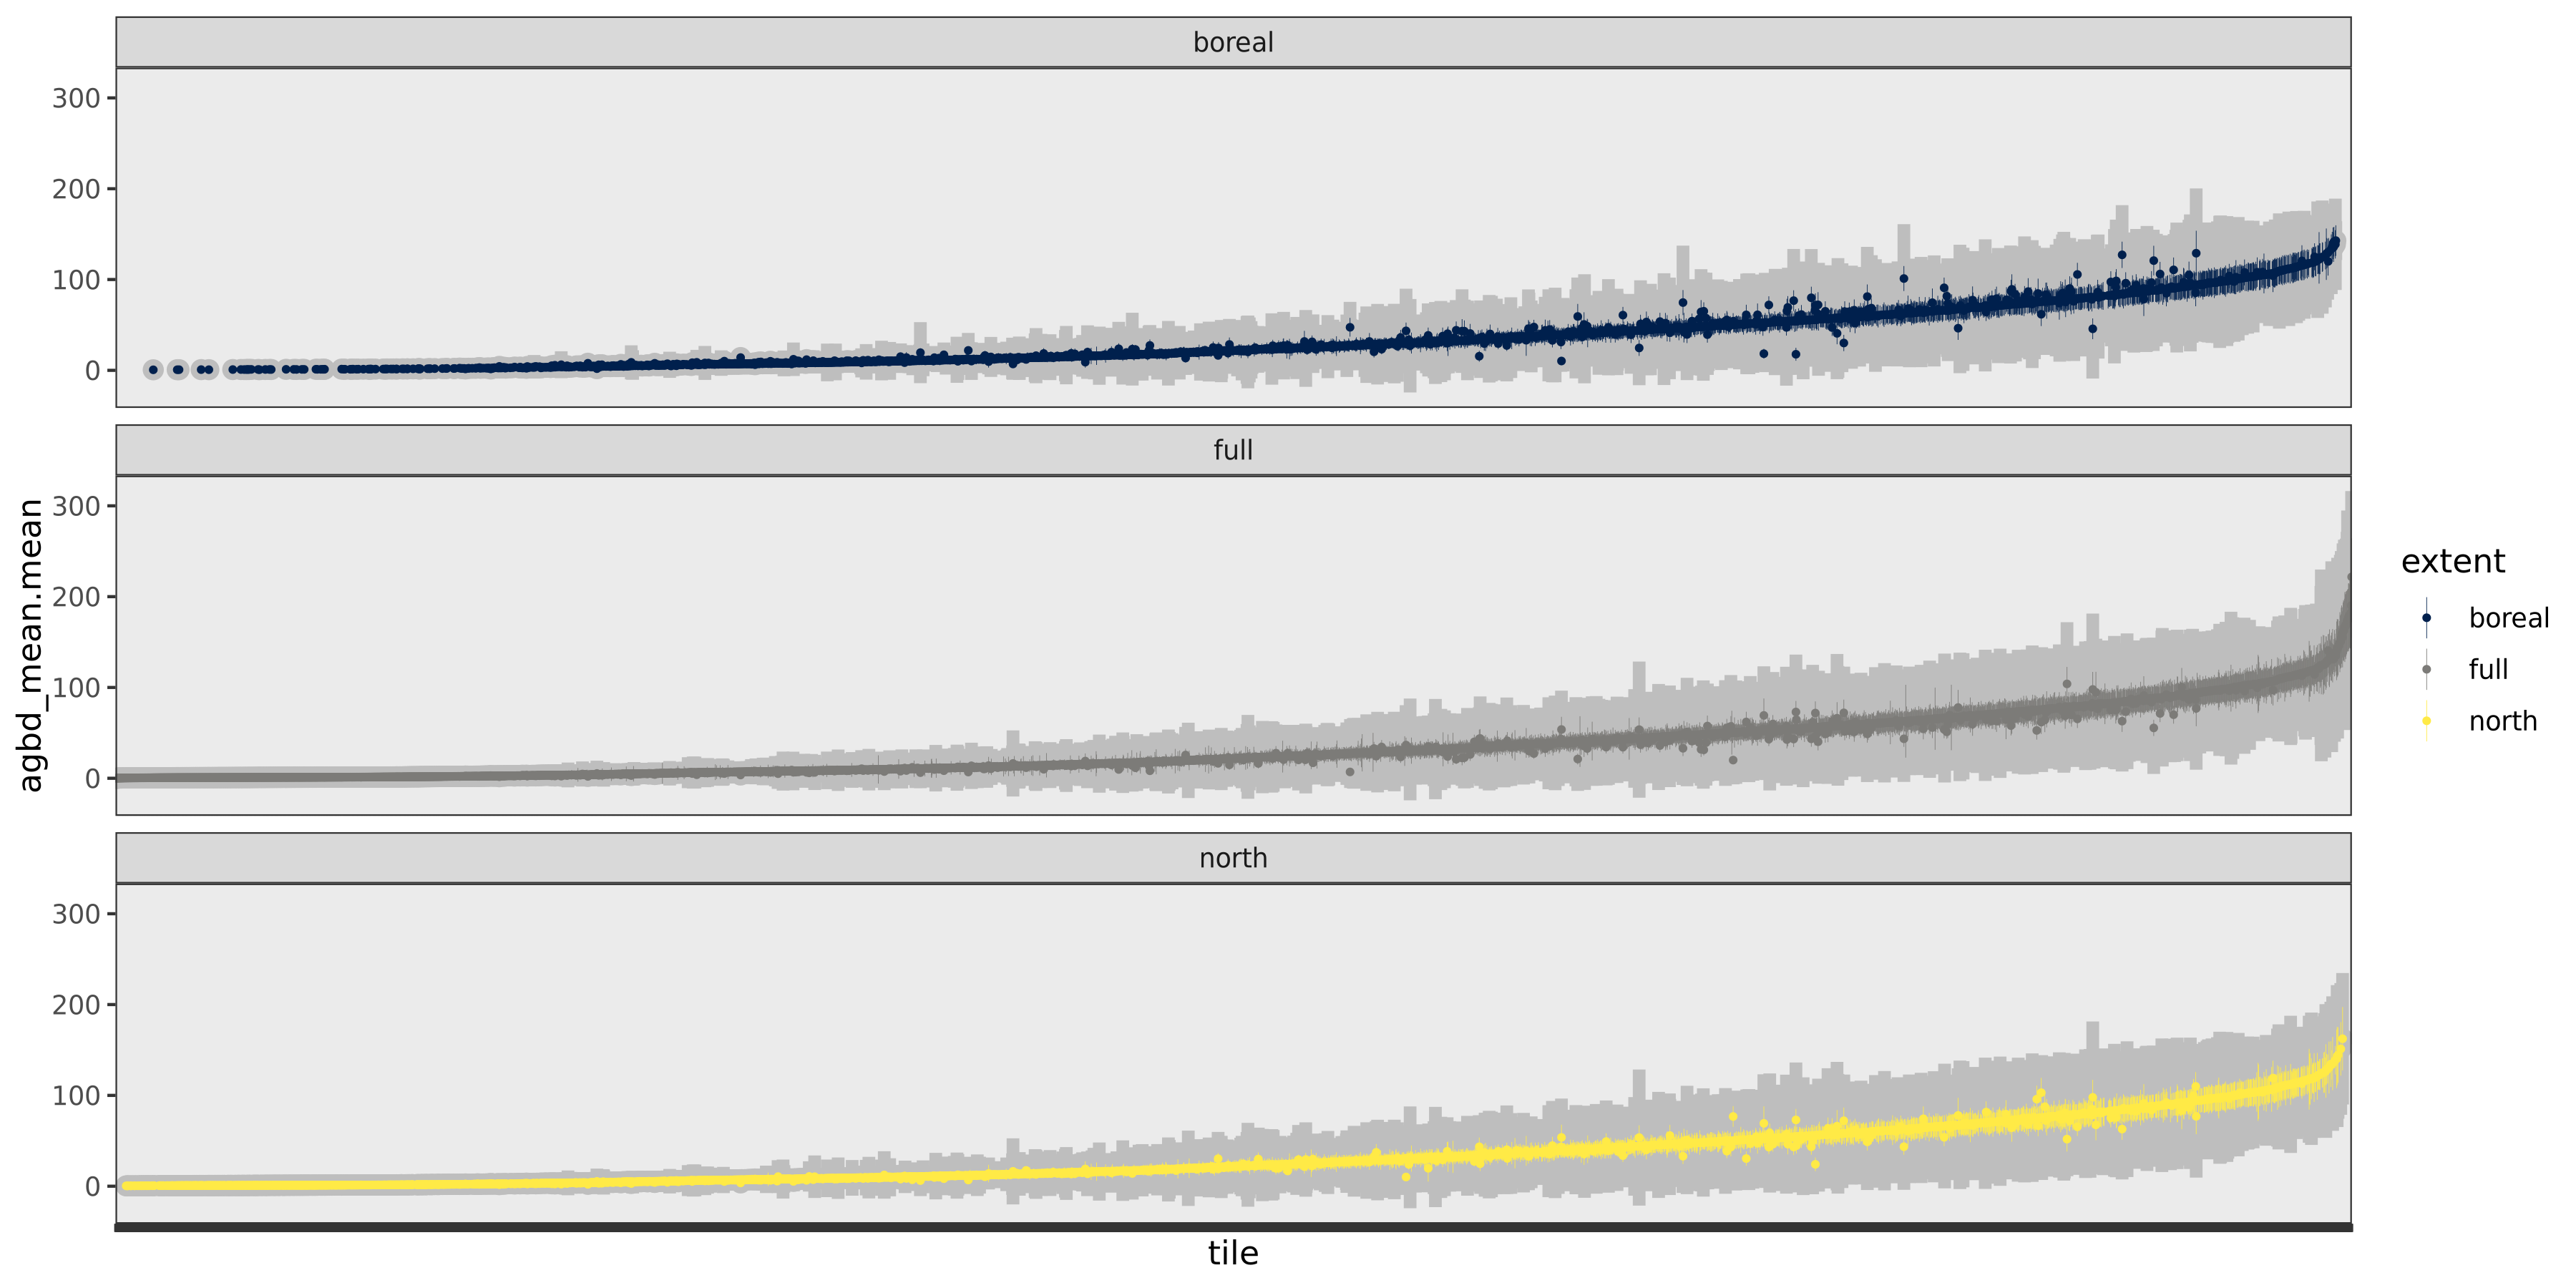

In [177]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)

ggplot(borealstats_df_long %>% filter(.data[[plot_stat_mean]] > 0)) + # aes(reorder(variable, value), value)

#
# This is the sd of the per-pixel MEAN values (larger) - shows geographic variation in AGBD within tile
#
    geom_pointrange(aes(x=reorder(factor(tile_num),.data[[plot_stat_mean]]) , y=.data[[plot_stat_mean]], ymin=.data[[plot_stat_mean]]-.data[[PLOT_STAT_ERRBAR_1]], ymax=.data[[plot_stat_mean]]+.data[[PLOT_STAT_ERRBAR_1]]), color='gray', linewidth=2
                    #, position=position_dodge(width=0.25)
                   ) +
#
# This is the mean of the per-pixel SD values (smaller)
#
    geom_pointrange(aes(x=reorder(factor(tile_num),.data[[plot_stat_mean]]) , y=.data[[plot_stat_mean]], ymin=.data[[plot_stat_mean]]-.data[[PLOT_STAT_ERRBAR_2]], ymax=.data[[plot_stat_mean]]+.data[[PLOT_STAT_ERRBAR_2]], color=extent)
                    , linewidth=0.1, size=0.01
                    #, position=position_dodge(width=0.25)
                   ) +
    scale_fill_viridis_d(option = 'cividis', aesthetics=c('fill','color')) +
    facet_wrap(~extent, ncol=1) +
    theme_bw() +
    theme(axis.text.x = element_blank()) +
    labs(x = 'tile')

In [ ]:
73.32011	12.10224

In [251]:
plot_stat_mean = 'Tile_mean_AGBD'
PLOT_STAT_ERRBAR_2 = 'Tile_mean_SD' # This is the mean of the per-pixel SD values (smaller)

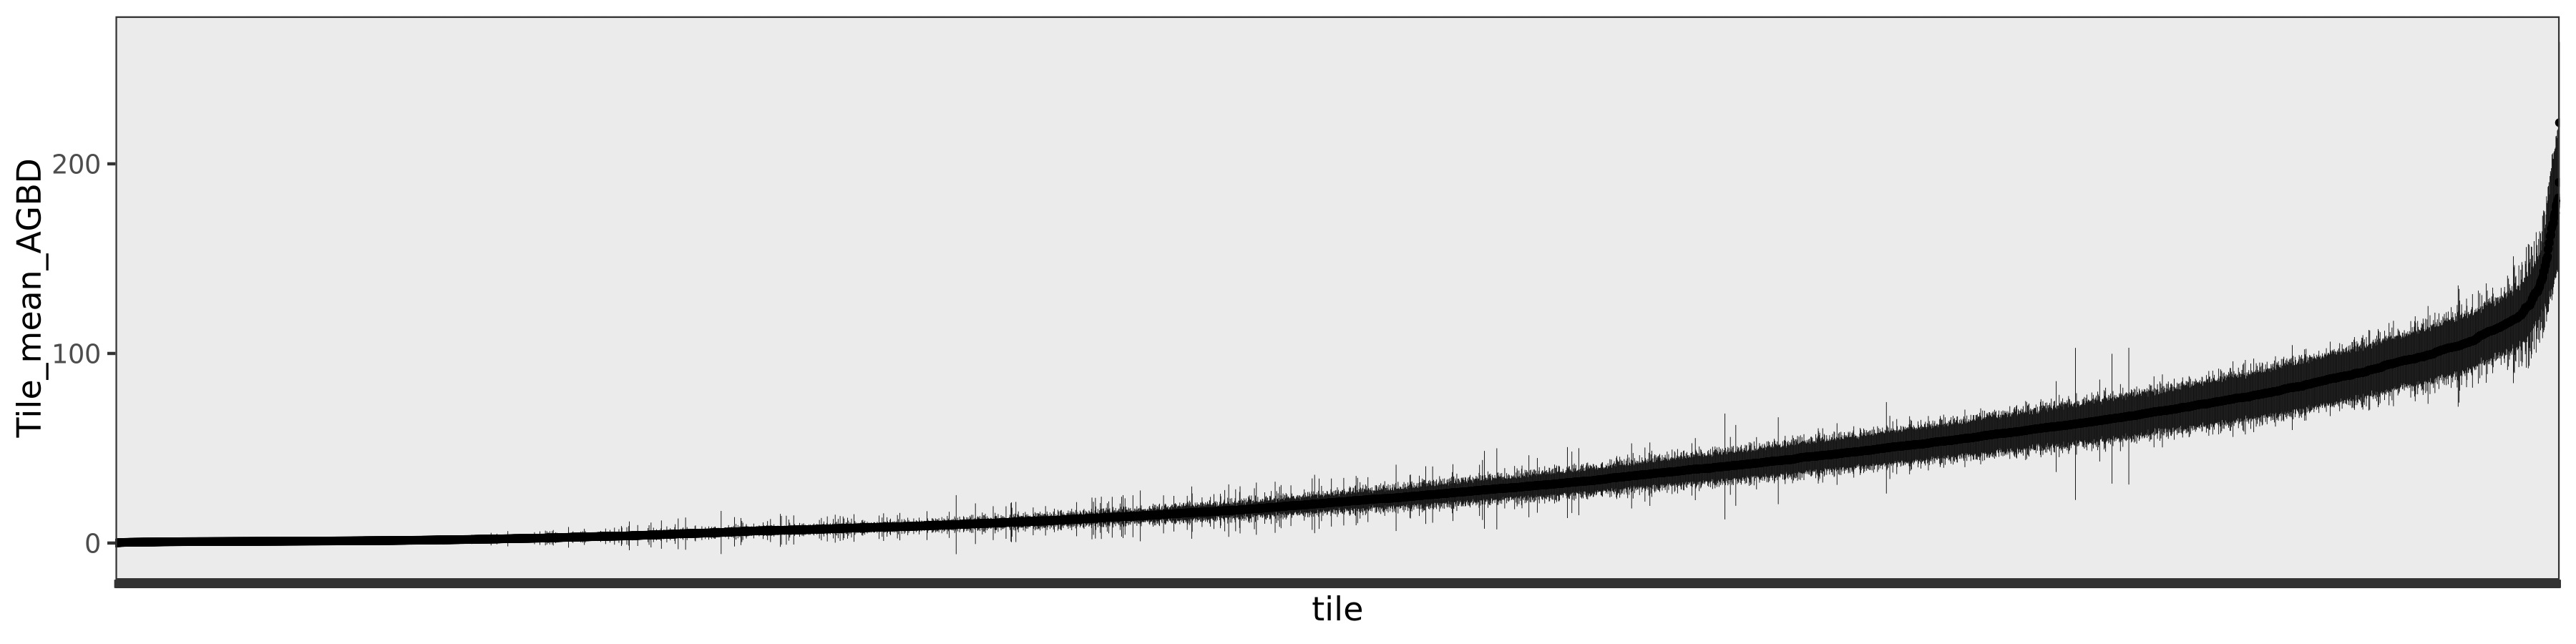

In [252]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300)

ggplot(tile_agb_smry %>% filter(.data[[plot_stat_mean]] > 0)) + # aes(reorder(variable, value), value)

# #
# # This is the sd of the per-pixel MEAN values (larger) - shows geographic variation in AGBD within tile
# #
#     geom_pointrange(aes(x=reorder(factor(tile_num),.data[[plot_stat_mean]]) , y=.data[[plot_stat_mean]], ymin=.data[[plot_stat_mean]]-.data[[PLOT_STAT_ERRBAR_1]], ymax=.data[[plot_stat_mean]]+.data[[PLOT_STAT_ERRBAR_1]]), color='gray', linewidth=2
#                     #, position=position_dodge(width=0.25)
#                    ) +
# #
# This is the mean of the per-pixel SD values (smaller)
#
    geom_pointrange(aes(x=reorder(factor(tile_num),.data[[plot_stat_mean]]) , y=.data[[plot_stat_mean]], ymin=.data[[plot_stat_mean]]-.data[[PLOT_STAT_ERRBAR_2]], ymax=.data[[plot_stat_mean]]+.data[[PLOT_STAT_ERRBAR_2]])
                    , linewidth=0.1, size=0.01
                    #, position=position_dodge(width=0.25)
                   ) +
    scale_fill_viridis_d(option = 'cividis', aesthetics=c('fill','color')) +
    #facet_wrap(~extent, ncol=1) +
    theme_bw() +
    theme(axis.text.x = element_blank()) +
    labs(x = 'tile')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


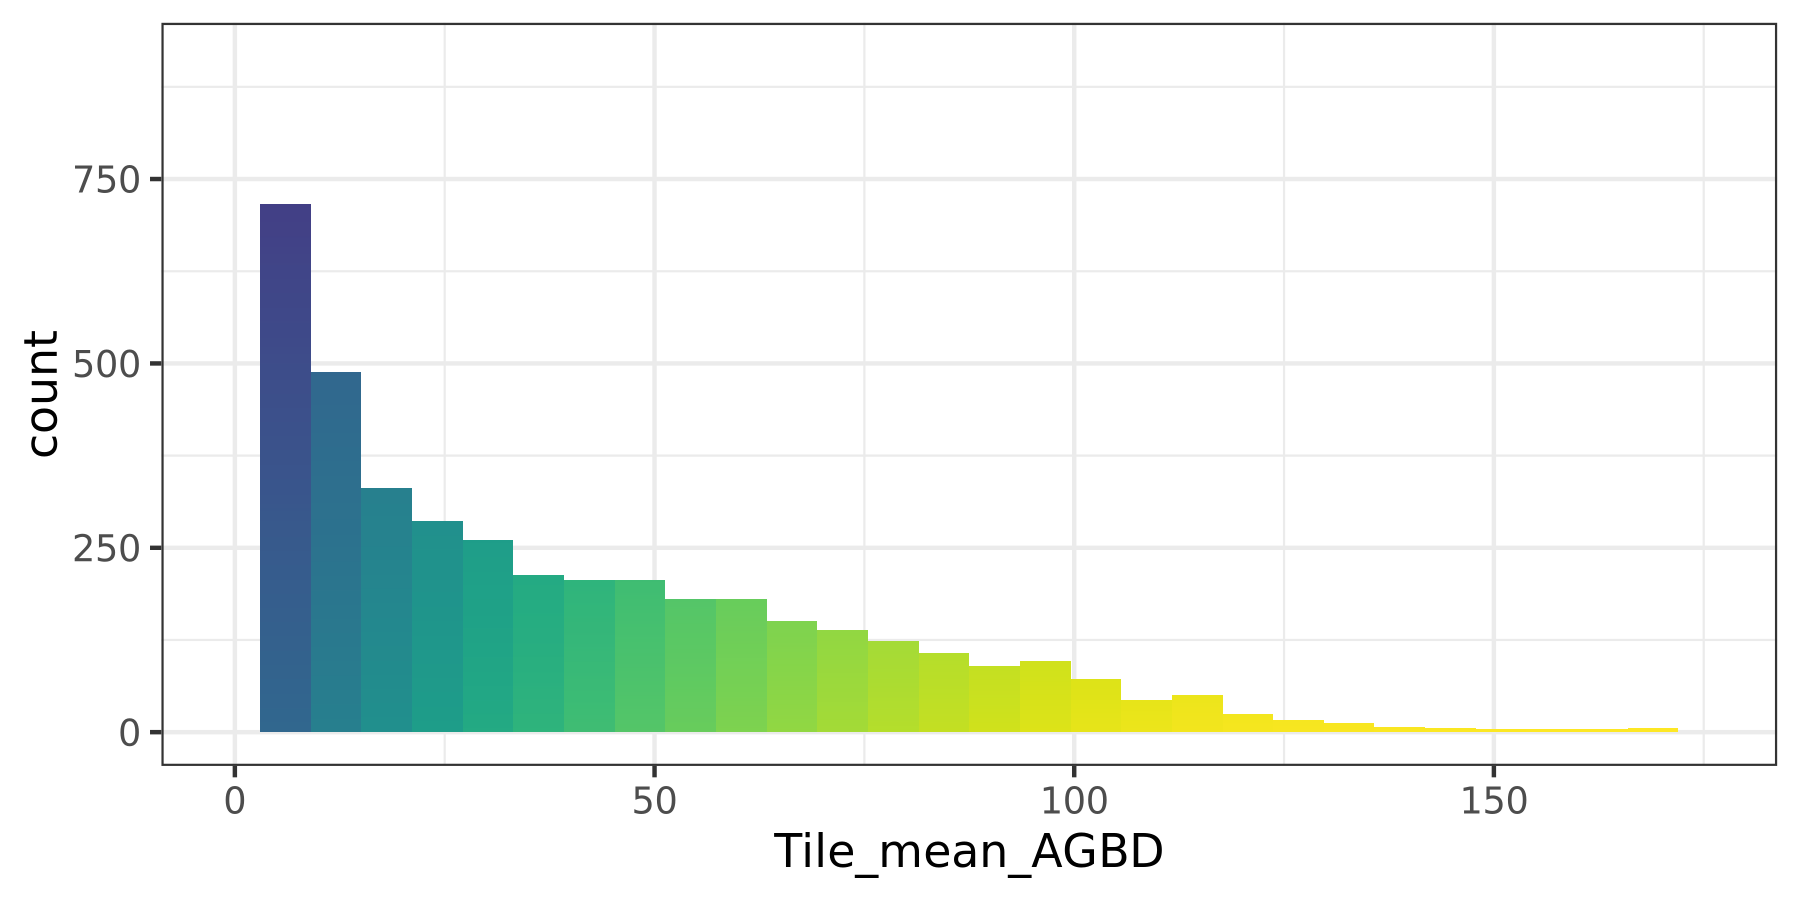

In [183]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 300)

hist_rmse = ggplot(tile_agb_smry) +
    geom_histogram(aes(x=Tile_mean_AGBD, fill=factor(Tile_mean_AGBD)), show.legend=FALSE)+
    scale_fill_viridis_d(option='viridis', direction=1) +
    lims(x=c(0,175)) +
    theme_bw()# +
    #custom_theme +
    #labs(x=expression("First rF model RMSE ["~Mg~ha^{-1}~"]"))



hist_rmse

### Join AGB RF stats to boreal tiles

In [184]:
dim(borealstats_df)

[1] 4950  112

In [253]:
# stats from SPRING 2022 version
#borealstats_df = read.csv("/projects/shared-buckets/lduncanson/borealstats.csv")

boreal_tiles_gcs_stats = fortify_sf(
                            boreal_tiles_gcs_DAAC %>% 
                            dplyr::select(tile_num) %>% 
                            dplyr::mutate(tile_num = as.numeric(tile_num)
                                          #,s3_path_tindex = AGB_tindex_master_fn
                                         ) %>% 
                            dplyr::left_join(borealstats_df, by = c('tile_num' = 'tile_num')) 
                                    )
head(boreal_tiles_gcs_stats %>% drop_na())

Regions defined for each Polygons


long      lat      order hole  piece id group tile_num agbd_mean_full.sum
1 -150.6017 68.07390 1     FALSE 1     1  1.1   3175     47520778          
2 -151.4968 67.34657 2     FALSE 1     1  1.1   3175     47520778          
3 -153.4462 67.66538 3     FALSE 1     1  1.1   3175     47520778          
4 -152.5977 68.40285 4     FALSE 1     1  1.1   3175     47520778          
5 -150.6017 68.07390 5     FALSE 1     1  1.1   3175     47520778          
6 -161.3912 66.19049 1     FALSE 1     2  2.1   3545     11835134          
  agbd_mean_full.min ⋯ imp_val_3 imp_val_4 tile_total_agb_mean_pg
1 0.3899874          ⋯ 241522.09 186524.97 0.004276870           
2 0.3899874          ⋯ 241522.09 186524.97 0.004276870           
3 0.3899874          ⋯ 241522.09 186524.97 0.004276870           
4 0.3899874          ⋯ 241522.09 186524.97 0.004276870           
5 0.3899874          ⋯ 241522.09 186524.97 0.004276870           
6 0.3677209          ⋯  49525.15  41362.27 0.001065162           
  tile_total_agb_sd_pg boreal_total_agb_mean_pg boreal_total_agb_sd_pg
1 0.0011987821         0                        0                     
2 0.0011987821         0                        0                     
3 0.0011987821         0                        0                     
4 0.0011987821         0                        0                     
5 0.0011987821         0                        0                     
6 0.0001153456         0                        0                     
  tile_total_agb_mean_mgha tile_total_agb_sd_mgha boreal_total_agb_mean_mgha
1 5.280086                 1.4799780              0                         
2 5.280086                 1.4799780              0                         
3 5.280086                 1.4799780              0                         
4 5.280086                 1.4799780              0                         
5 5.280086                 1.4799780              0                         
6 1.315015                 0.1424019              0                         
  boreal_total_agb_sd_mgha
1 0                       
2 0                       
3 0                       
4 0                       
5 0                       
6 0

#### Mapping function

In [254]:
PLOT_SF = 0.75

In [351]:
options(repr.plot.width = 16, repr.plot.height =8, repr.plot.res = 300)

DO_MAP <- function(boreal_tiles_gcs_stats, MAP_VAR='tile_total_agb_mean_pg', 
                        MAP_TITLE='Aboveground woody biomass stock\nensemble mean [Pg]', 
                        MAP_LIMS=c(0, 0.08), MAP_PAL='viridis'
                       ){

    TMP_DF = boreal_tiles_gcs_stats 
    
    m_plot = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,45,90),  
                         BOREAL_SHP_FN = wwf_circ_dis_fn,
                         LAYER_LIST = list(geom_polygon(data = TMP_DF, 
                                                        aes_string(x = "long", y = "lat", group = "group", fill=MAP_VAR), size=0.1)
                                          )
                        ) + 
        theme(
            legend.title=element_text(size=rel(1.5)), # 1.25
            legend.text=element_text(size=rel(1)), #0.75
            plot.caption = element_text(size = 7)
        ) +
        labs(caption='v3.0') +
        scale_fill_viridis(option = MAP_PAL, limits = MAP_LIMS, oob = scales::squish) +
        guides(fill=guide_colorbar(title=MAP_TITLE, 
                                   title.position = "top", label.position = "bottom", keywidth = unit(8, "cm"), keyheight = unit(.25, "cm"), nrow=3)) 
                
    return(m_plot)
}

### AGBD & Uncertainty Boreal

In [737]:
#names(boreal_tiles_gcs_stats)

[1] "Using sf and coercing to Spatial object..."
Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/my-public-bucket/databank/arc/wwf_circumboreal_Dissolve.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -5281040 ymin: -60527.9 xmax: 3959203 ymax: 8747447
Projected CRS: NAD83 / Alaska Albers


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


[1] "Using sf and coercing to Spatial object..."
Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/my-public-bucket/databank/arc/wwf_circumboreal_Dissolve.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -5281040 ymin: -60527.9 xmax: 3959203 ymax: 8747447
Projected CRS: NAD83 / Alaska Albers


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


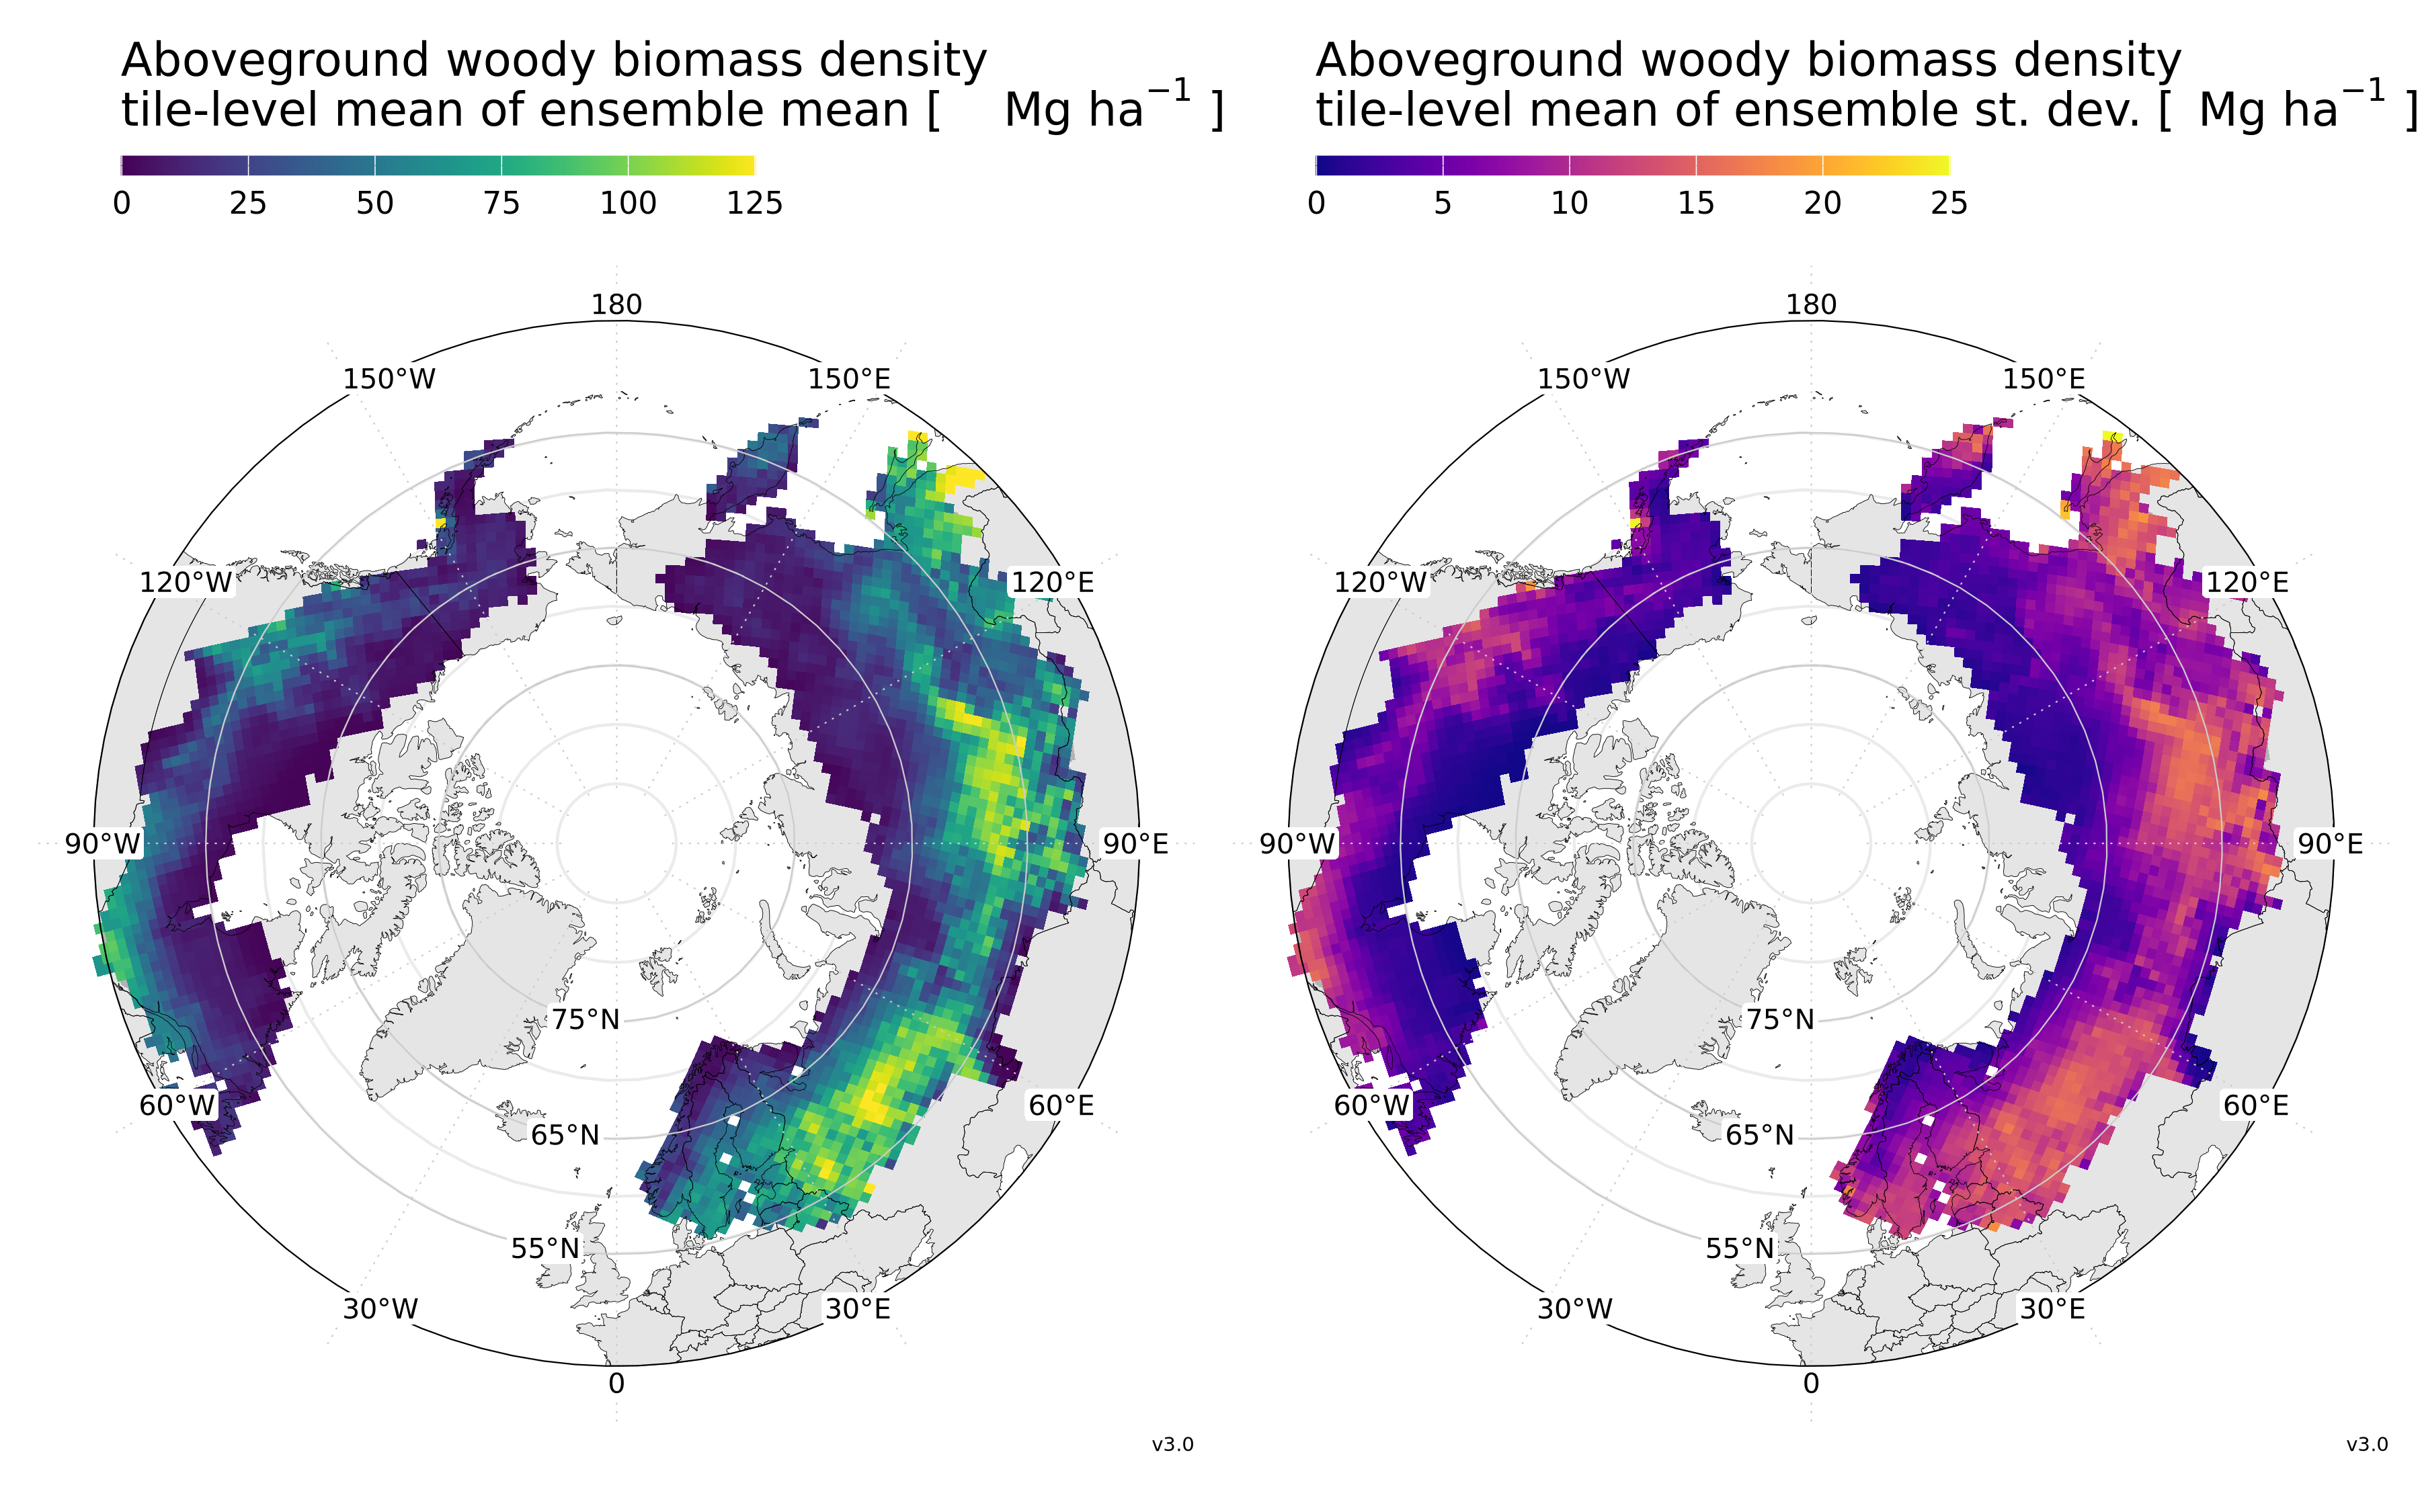

In [352]:
options(repr.plot.width = 16 * PLOT_SF, repr.plot.height = 10 * PLOT_SF, repr.plot.res = 300)

boreal_tiles_boreal = boreal_tiles_gcs_stats %>% filter(agbd_mean_boreal.mean>0)

m_agbd_mean_boreal = DO_MAP( boreal_tiles_boreal, MAP_VAR='agbd_mean_boreal.mean', 
                            #MAP_TITLE='Aboveground woody biomass density\ntile-level mean of ensemble mean [m]'
                            MAP_TITLE=expression("Aboveground woody biomass density\ntile-level mean of ensemble mean ["~Mg~ha^{-1}~"]")
                            , MAP_LIMS=c(0, 125), MAP_PAL='viridis'
                                )

m_agbd_sd_boreal   = DO_MAP( boreal_tiles_boreal , MAP_VAR='agbd_sd_boreal.mean', 
                                #MAP_TITLE='Aboveground woody biomass density\ntile-level mean of ensemble st. dev. [m]'
                            MAP_TITLE=expression("Aboveground woody biomass density\ntile-level mean of ensemble st. dev. ["~Mg~ha^{-1}~"]")
                            , MAP_LIMS=c(0, 25), MAP_PAL='plasma'
                                )

m_TILE_mean = m_agbd_mean_boreal | m_agbd_sd_boreal
m_TILE_mean

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


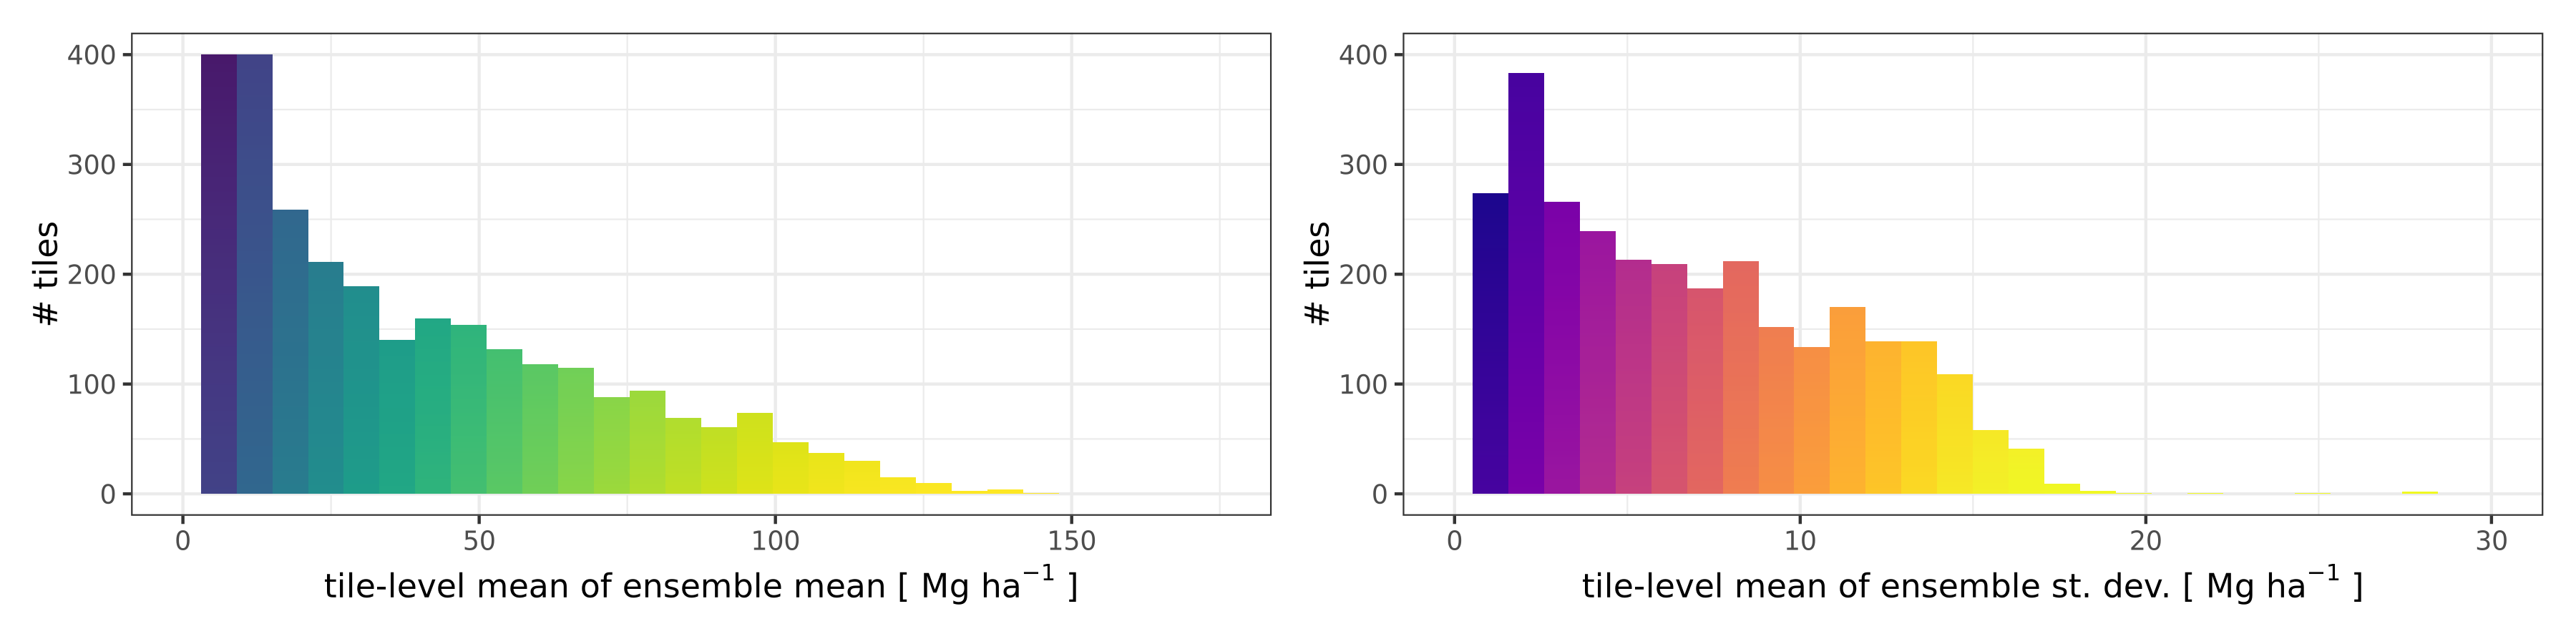

In [353]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 300)

hist_agbd_mean.mean = ggplot(borealstats_df) +
    geom_histogram(aes(x=agbd_mean_boreal.mean, fill=factor(agbd_mean_boreal.mean)), show.legend=FALSE)+
    scale_fill_viridis_d(option='viridis', direction=1) +
    lims(x=c(0,175), y=c(0,400)) +
    theme_bw() +
    labs(x=expression("tile-level mean of ensemble mean ["~Mg~ha^{-1}~"]"), y='# tiles')

hist_agbd_sd.mean = ggplot(borealstats_df) +
    geom_histogram(aes(x=agbd_sd_boreal.mean, fill=factor(agbd_sd_boreal.mean)), show.legend=FALSE)+
    scale_fill_viridis_d(option='plasma', direction=1) +
    lims(x=c(0,30), y=c(0,400)) +
    theme_bw() +
    labs(x=expression("tile-level mean of ensemble st. dev. ["~Mg~ha^{-1}~"]"), y='# tiles')
    #custom_theme +
    #labs(x=expression("First rF model RMSE ["~Mg~ha^{-1}~"]"))

hist_agbd_mean.mean | hist_agbd_sd.mean

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


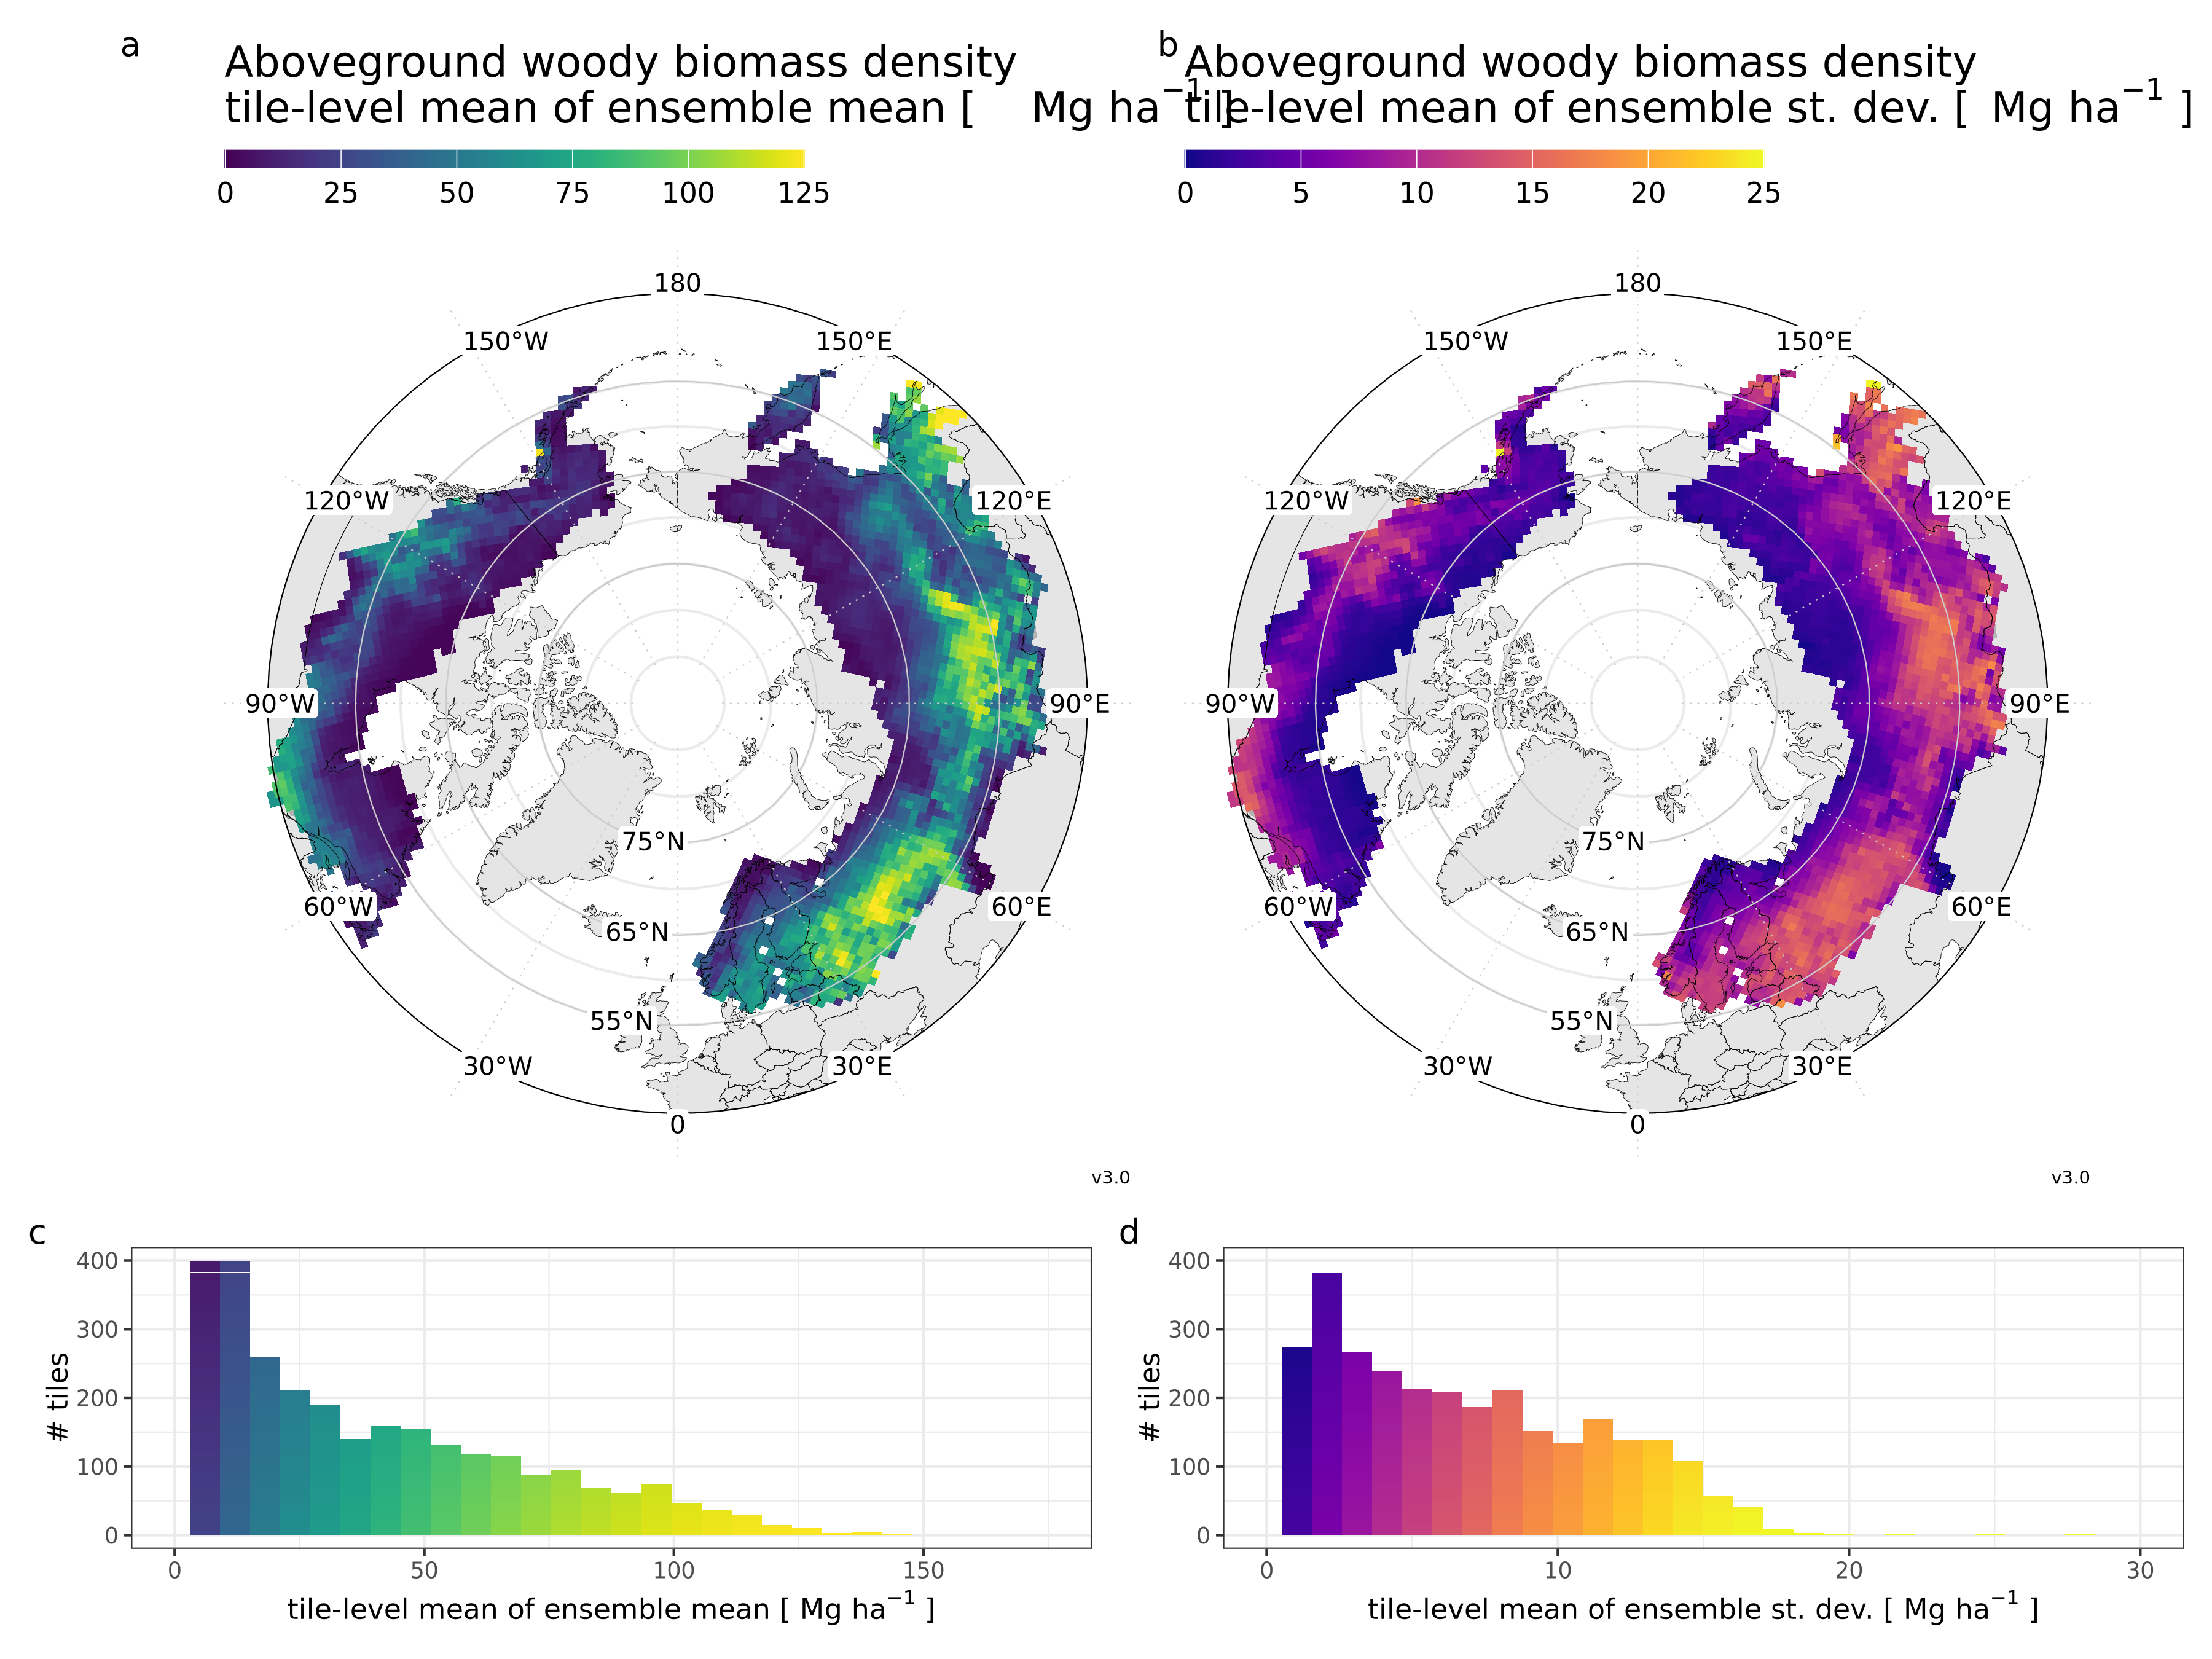

In [359]:
options(repr.plot.width = 16 * PLOT_SF, repr.plot.height = 12 * PLOT_SF, repr.plot.res = 300, warn=-1)

layout = "
AA
AA
AA
BB
"
combined_ensemble_stats = (m_TILE_mean / (hist_agbd_mean.mean | hist_agbd_sd.mean) ) +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))

combined_ensemble_stats

### Use for boreal AGB manuscript

In [358]:
EXPORT_MAPS_PNG_PDF(combined_ensemble_stats, OUT_FIGURE_DIR, 'BOREAL_AGBD', 'MEAN_SD_map_hist', EXPORT_TIME_STR=format(Sys.time(), "_%Y%m%d"), FIG_DIMS=c(16,12))

/projects/my-public-bucket/boreal_AGB/paper_figs/map_BOREAL_AGBD_MEAN_SD_map_hist_20250722.png


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


/projects/my-public-bucket/boreal_AGB/paper_figs/map_BOREAL_AGBD_MEAN_SD_map_hist_20250722.pdf


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


###  Use for MAAP STAC thumbnail

In [361]:
EXPORT_MAPS_PNG_PDF(m_TILE_mean, OUT_FIGURE_DIR, 'BOREAL_AGBD', 'MEAN_SD_map', EXPORT_TIME_STR=format(Sys.time(), "_%Y%m%d"), FIG_DIMS=c(16,10))

/projects/my-public-bucket/boreal_AGB/paper_figs/map_BOREAL_AGBD_MEAN_SD_map_20250722.png
/projects/my-public-bucket/boreal_AGB/paper_figs/map_BOREAL_AGBD_MEAN_SD_map_20250722.pdf


## Check extract() & global()

In [6]:
library(terra)

In [13]:
boreal_polygon_file='/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve_reprj.geojson'
boreal_poly <- vect(boreal_polygon_file)
crs(boreal_poly)

[1] "GEOGCRS[\"WGS 84\",\n    DATUM[\"World Geodetic System 1984\",\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS[\"geodetic latitude (Lat)\",north,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        AXIS[\"geodetic longitude (Lon)\",east,\n            ORDER[2],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n    ID[\"EPSG\",4326]]"

In [8]:
fn_test = 's3://maap-ops-workspace/aliz237/dps_output/run_boreal_biomass_map/v3.0.0/AGB_H30_2020/full_run/2025/06/06/12/47/28/330399/boreal_agb_2020_202506061749236975_0001630.tif'

In [9]:
r = terra::rast(str_replace(fn_test, "s3://","/vsis3/"))

In [10]:
mean_agb = r[[1]]
var_agb = r[[1]]^2

In [11]:
crs(boreal_poly) <- crs(mean_agb)
boreal_map <- extract(mean_agb, boreal_poly, fun=sum, na.rm=TRUE, ID=FALSE)
boreal_var <- extract(var_agb, boreal_poly, fun=sum, na.rm=TRUE, ID=FALSE)

ERROR: Error in UseMethod("extract"): no applicable method for 'extract' applied to an object of class "SpatRaster"


ERROR: [1m[33mError[39m in `extract()`:[22m
[1m[22m[33m![39m Arguments in `...` must be used.
[31m✖[39m Problematic arguments:
[36m•[39m fun = sum
[36m•[39m na.rm = TRUE
[36m•[39m ID = FALSE
[36mℹ[39m Did you misspell an argument name?
